In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls
from imblearn.over_sampling import SMOTE
import warnings
import time
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

!pip install textsearch
!pip install contractions
#!pip install pyspellchecker
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
import contractions
from contractions import contractions_dict
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
#from spellchecker import SpellChecker
from nltk.stem.snowball import SnowballStemmer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



     |████████████████████████████████| 327kB 3.8MB/s 
     |████████████████████████████████| 286kB 5.2MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85408 sha256=f85e15c299bd5095e605f72c38ce0d6b4f762339d4a9af570ee3d14258d75e8a
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick
     |████████████████████████████████| 2.7MB 3.9MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [4]:
prdf = pd.read_csv('/data/sample30.csv', encoding='latin-1')

In [5]:
prdf.shape

(30000, 15)

In [6]:
prdf.dtypes

id                      object
brand                   object
categories              object
manufacturer            object
name                    object
reviews_date            object
reviews_didPurchase     object
reviews_doRecommend     object
reviews_rating          int64 
reviews_text            object
reviews_title           object
reviews_userCity        object
reviews_userProvince    object
reviews_username        object
user_sentiment          object
dtype: object

In [7]:
prdf=prdf.rename({'id': 'product_id', 'reviews_didPurchase': 'purchased', 'reviews_doRecommend': 'recommended',
           'reviews_rating': 'rating', 'reviews_text': 'review_original', 'reviews_title': 'review_title',
           'reviews_username': 'user_name', 'reviews_date': 'review_date',
           'reviews_userProvince': 'province', 'reviews_userCity': 'city'}, axis=1)

In [8]:
prdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   product_id       30000 non-null  object
 1   brand            30000 non-null  object
 2   categories       30000 non-null  object
 3   manufacturer     29859 non-null  object
 4   name             30000 non-null  object
 5   review_date      29954 non-null  object
 6   purchased        15932 non-null  object
 7   recommended      27430 non-null  object
 8   rating           30000 non-null  int64 
 9   review_original  30000 non-null  object
 10  review_title     29810 non-null  object
 11  city             1929 non-null   object
 12  province         170 non-null    object
 13  user_name        29937 non-null  object
 14  user_sentiment   29999 non-null  object
dtypes: int64(1), object(14)
memory usage: 3.4+ MB


In [9]:
prdf.describe()

,rating
count,30000.000000
mean,4.483133
std,0.988441
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [10]:
prdf.isnull().sum()

product_id         0    
brand              0    
categories         0    
manufacturer       141  
name               0    
review_date        46   
purchased          14068
recommended        2570 
rating             0    
review_original    0    
review_title       190  
city               28071
province           29830
user_name          63   
user_sentiment     1    
dtype: int64

In [11]:
prdf.user_sentiment.value_counts()

Positive    26632
Negative    3367 
Name: user_sentiment, dtype: int64

In [12]:
print(round(prdf.isnull().sum()*100/len(prdf), 2))

product_id         0.00 
brand              0.00 
categories         0.00 
manufacturer       0.47 
name               0.00 
review_date        0.15 
purchased          46.89
recommended        8.57 
rating             0.00 
review_original    0.00 
review_title       0.63 
city               93.57
province           99.43
user_name          0.21 
user_sentiment     0.00 
dtype: float64


In [13]:
# Dropping columns having more than 90% missing values
prdf.drop(['city', 'province'], axis=1, inplace=True)

In [14]:
#Drop rows where title or user or date are null which doesnt seem to be added though proper channels or system
prdf=prdf.dropna(subset=['user_sentiment', 'review_title', 'user_name', 'review_date'])

In [15]:
#Strip prefixed and suffixed spaces from the text or string based columns
prdf['review_title'] = prdf['review_title'].str.strip()
prdf['manufacturer'] = prdf['manufacturer'].str.strip()
prdf['brand'] = prdf['brand'].str.strip()
prdf['categories'] = prdf['categories'].str.strip()

In [16]:
prdf.isnull().sum()

product_id         0    
brand              0    
categories         0    
manufacturer       141  
name               0    
review_date        0    
purchased          13776
recommended        2336 
rating             0    
review_original    0    
review_title       0    
user_name          0    
user_sentiment     0    
dtype: int64

In [17]:
# Check the brands that are reviewed most
prdf.brand.value_counts()[:20]

Clorox                        10564
Warner Home Video             3324 
Disney                        1196 
L'oreal Paris                 1186 
FOX                           887  
Burt's Bees                   878  
Sony Pictures                 845  
Summit Entertainment          813  
Nexxus                        691  
Universal Home Video          668  
Olay                          637  
Warner Bros.                  458  
Lundberg                      414  
Clear Scalp & Hair Therapy    370  
Hoover                        349  
Windex                        348  
Avery                         314  
Pendaflex                     310  
Aveeno                        302  
Tostitos                      286  
Name: brand, dtype: int64

In [18]:
# Check the manufacturers that are reviewed most
prdf.manufacturer.value_counts()[:20]

Clorox                    8525
Test                      3324
AmazonUs/CLOO7            2039
L'oreal Paris             1232
Walt Disney               1139
Burt's Bees               873 
SONY CORP                 845 
Twentieth Century Fox     757 
P&G                       730 
Nexxus Beauty Products    691 
Summit Entertainment      672 
Universal                 668 
Lundberg Family Farms     412 
Clear                     370 
Hoover                    349 
Windex                    348 
Avery Dennison            313 
Esselte Corporation       310 
Aveeno Baby               302 
Tostitos                  265 
Name: manufacturer, dtype: int64

In [19]:
# Check null value count in manufacturer column
prdf.manufacturer.isnull().sum()

141

In [20]:
# Fill blanks in place of nulls in manufacturer
prdf['manufacturer'].fillna('', inplace=True)

In [21]:
prdf.manufacturer.isnull().sum()

0

In [22]:
prdf[['manufacturer', 'brand', 'name']].head(50)

,manufacturer,brand,name
0,Universal Music Group / Cash Money,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd)
1,Lundberg,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes
2,Lundberg,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes
3,K-Y,K-Y,K-Y Love Sensuality Pleasure Gel
4,K-Y,K-Y,K-Y Love Sensuality Pleasure Gel
5,K-Y,K-Y,K-Y Love Sensuality Pleasure Gel
6,K-Y,K-Y,K-Y Love Sensuality Pleasure Gel
7,K-Y,K-Y,K-Y Love Sensuality Pleasure Gel
8,K-Y,K-Y,K-Y Love Sensuality Pleasure Gel
9,K-Y,K-Y,K-Y Love Sensuality Pleasure Gel


In [23]:
# Since manufacturer, brand and name form a combination which can represent a product, 
# and we can simply use a single column by concatenating all these values. 
# However, manufacturer and brand have same values in some cases, where we can assume that the name is already having that prefixed.
# In case, where manufacturer is different than the brand, we can prefix manufacturer with name
prdf['product_name'] = np.where(prdf['manufacturer'].str.lower() == prdf['brand'].str.lower(), 
                           prdf['name'], prdf['manufacturer'].astype(str)+' '+prdf['name'])

In [24]:
prdf[['manufacturer', 'brand', 'product_name']].head(50)

,manufacturer,brand,product_name
0,Universal Music Group / Cash Money,Universal Music,Universal Music Group / Cash Money Pink Friday: Roman Reloaded Re-Up (w/dvd)
1,Lundberg,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes
2,Lundberg,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes
3,K-Y,K-Y,K-Y Love Sensuality Pleasure Gel
4,K-Y,K-Y,K-Y Love Sensuality Pleasure Gel
5,K-Y,K-Y,K-Y Love Sensuality Pleasure Gel
6,K-Y,K-Y,K-Y Love Sensuality Pleasure Gel
7,K-Y,K-Y,K-Y Love Sensuality Pleasure Gel
8,K-Y,K-Y,K-Y Love Sensuality Pleasure Gel
9,K-Y,K-Y,K-Y Love Sensuality Pleasure Gel


In [25]:
prdf['product_name'].value_counts()[:20]

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                                              8524
Test Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                                   3324
AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner                                                    2039
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz                         1186
Walt Disney Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                        1139
Burt's Bees Lip Shimmer, Raisin                                                                        873 
SONY CORP The Resident Evil Collection 5 Discs (blu-Ray)                                               845 
Twentieth Century Fox Mike Dave Need Wedding Dates (dvd + Digital)                                     757 
Nexxus Beauty Products Nexxus Exxtra Gel Style Creation Sculptor                                       691 
Red (special Edition) (dvdvi

In [26]:
# Let's check the rows where the manufacturer is 'Test'
prdf[prdf['manufacturer']=='Test'].head(2)

,product_id,brand,categories,manufacturer,name,review_date,purchased,recommended,rating,review_original,review_title,user_name,user_sentiment,product_name
22884,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",Test,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,2015-08-05T00:00:00.000Z,NaN,False,1,could have left this one on the shelf but it had a great box,awful,primoconcept,Positive,Test Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd
22885,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",Test,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,2015-07-13T00:00:00.000Z,NaN,False,1,"This movie is much worse that expected. The 1997 Broderick movie is much better. The producers went back to the popular Japanese format that were great for teenagers, but just doesn't work for adults.",Much worse than expected,terrym,Positive,Test Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd


In [27]:
# In case of product 'Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd', the manufacturer is given as 'Test' by mistake.
# Let's check the value counts of the brand column for the rows with manufacturer as 'Test'
prdf[prdf['manufacturer']=='Test'].brand.value_counts()

Warner Home Video    3324
Name: brand, dtype: int64

In [28]:
# Since the product seems to be related to movie and that too with same brand and manufacturer, let's check the value counts of id
prdf[prdf['manufacturer']=='Test'].product_id.value_counts()

AVpfPaoqLJeJML435Xk9    3324
Name: product_id, dtype: int64

In [29]:
# All 3324 records seem to be of same movie product and found to be that of Warner Home Video brand.
# let's update the product correctly by prefixing 'Wrner Home Video' which is correctly given in 'brand' column
# 'Warner Home Video' which is the same as brand in this case
prdf['product_name']=np.where(prdf['manufacturer'].str.lower() == 'test', 
                              prdf['brand'].astype(str)+' '+prdf['name'], prdf['product_name'])

In [30]:
prdf['product_name'].value_counts()[:20]

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                                              8524
Warner Home Video Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                      3324
AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner                                                    2039
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz                         1186
Walt Disney Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                        1139
Burt's Bees Lip Shimmer, Raisin                                                                        873 
SONY CORP The Resident Evil Collection 5 Discs (blu-Ray)                                               845 
Twentieth Century Fox Mike Dave Need Wedding Dates (dvd + Digital)                                     757 
Nexxus Beauty Products Nexxus Exxtra Gel Style Creation Sculptor                                       691 
Red (special Edition) (dvdvi

In [31]:
prdf.shape

(29707, 14)

In [32]:
prdf.isnull().sum()

product_id         0    
brand              0    
categories         0    
manufacturer       0    
name               0    
review_date        0    
purchased          13776
recommended        2336 
rating             0    
review_original    0    
review_title       0    
user_name          0    
user_sentiment     0    
product_name       0    
dtype: int64

In [33]:
# The reviews are not so much relevant with the dates, however we can analyze them based on year which can be of some help in recommednations
prdf['year'] = pd.to_datetime(prdf['review_date'], errors ='coerce')
prdf['year'] = prdf['year'].dt.strftime('%Y')
prdf.head()

,product_id,brand,categories,manufacturer,name,review_date,purchased,recommended,rating,review_original,review_title,user_name,user_sentiment,product_name,year
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,Positive,Universal Music Group / Cash Money Pink Friday: Roman Reloaded Re-Up (w/dvd),2012
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,Positive,Lundberg Organic Cinnamon Toast Rice Cakes,2017
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,dorothy w,Positive,Lundberg Organic Cinnamon Toast Rice Cakes,2017
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",Disappointed,rebecca,Negative,K-Y Love Sensuality Pleasure Gel,2016
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,Negative,K-Y Love Sensuality Pleasure Gel,2016


In [34]:
# With date conversion, there might be cases of errors due to which the year column might get null values
prdf['year'].isnull().sum()

8

In [35]:
prdf[prdf['year'].isnull()]['review_date']

28421     hooks slide or swivel into any desired position."
28422     hooks slide or swivel into any desired position."
28423     hooks slide or swivel into any desired position."
28424     hooks slide or swivel into any desired position."
28425     hooks slide or swivel into any desired position."
28426     hooks slide or swivel into any desired position."
28427     hooks slide or swivel into any desired position."
28428     hooks slide or swivel into any desired position."
Name: review_date, dtype: object

In [36]:
# We can safely drop the rows with invalid date values by dropping rows where we have year as null
prdf=prdf.dropna(subset=['year'])

In [37]:
prdf.isnull().sum()

product_id         0    
brand              0    
categories         0    
manufacturer       0    
name               0    
review_date        0    
purchased          13776
recommended        2336 
rating             0    
review_original    0    
review_title       0    
user_name          0    
user_sentiment     0    
product_name       0    
year               0    
dtype: int64

In [38]:
# We can drop rows with recommended column as null, as they seem to be not so useful for our analysis further which basically depend
# on the users choice and their selection of whether they recommend or not.
prdf=prdf.dropna(subset=['recommended'])

### **name**, **manufacturer** and **brand** are redundant, which are replaced by product by concatenating both.
### **date** is no more required as it is replaced by **year**
### **purchased** and **recommended** suggests can be used further to analyze and validate our recommendations

In [39]:
prdf.drop(['name', 'manufacturer', 'brand', 'review_date'], axis=1, inplace=True)

In [40]:
prdf.shape

(27363, 11)

In [41]:
# title and review can be merged for better content to develop recommendation system
prdf['review_merged'] = prdf['review_title'] + ' ' + prdf['review_original']

In [42]:
totalRecommended = len(prdf[prdf['recommended']==True])
print('Number rows with recommended true', totalRecommended)
totalNotRecommended = len(prdf[prdf['recommended']==False])
print('Number rows with recommended false', totalNotRecommended)
totalPositive = len(prdf[prdf['user_sentiment']=='Positive'])
print('Number rows with Sentiment Positive', totalPositive)
totalNegative = len(prdf[prdf['user_sentiment']=='Negative'])
print('Number rows with Sentiment Negative', totalNegative)
totalPositiveRating = len(prdf[prdf['rating']>2])
print('Number rows with Positive Rating > 2', totalPositiveRating)
totalNegativeRating = len(prdf[prdf['rating']<3])
print('Number rows with Negative Rating < 3', totalNegativeRating)
df_tmp1 = prdf[(prdf['recommended']==True) & (prdf['user_sentiment']=='Positive') & (prdf['rating']>2)]
print('Number of rows with recommended true and sentiment as positive and rating 3, 4 and 5', len(df_tmp1))
df_tmp1 = prdf[(prdf['recommended']==True) & (prdf['user_sentiment']=='Negative') & (prdf['rating']>2)]
print('Number of rows with recommended true and sentiment as negative and rating 3, 4 and 5', len(df_tmp1))
df_tmp1 = prdf[(prdf['recommended']==False) & (prdf['user_sentiment']=='Positive') & (prdf['rating']>2)]
print('Number of rows with recommended false and sentiment as positive and rating 3, 4 and 5', len(df_tmp1))
df_tmp1 = prdf[(prdf['recommended']==False) & (prdf['user_sentiment']=='Negative') & (prdf['rating']>2)]
print('Number of rows with recommended false and sentiment as negative and rating 3, 4 and 5', len(df_tmp1))
df_tmp1 = prdf[(prdf['recommended']==True) & (prdf['user_sentiment']=='Positive') & (prdf['rating']<3)]
print('Number of rows with recommended true and sentiment as positive and rating 1 and 2', len(df_tmp1))
df_tmp1 = prdf[(prdf['recommended']==True) & (prdf['user_sentiment']=='Negative') & (prdf['rating']<3)]
print('Number of rows with recommended true and sentiment as negative and rating 1 and 2', len(df_tmp1))
df_tmp1 = prdf[(prdf['recommended']==False) & (prdf['user_sentiment']=='Positive') & (prdf['rating']<3)]
print('Number of rows with recommended false and sentiment as positive and rating 1 and 2', len(df_tmp1))
df_tmp1 = prdf[(prdf['recommended']==False) & (prdf['user_sentiment']=='Negative') & (prdf['rating']<3)]
print('Number of rows with recommended false and sentiment as negative and rating 1 and 2', len(df_tmp1))

Number rows with recommended true 25814
Number rows with recommended false 1549
Number rows with Sentiment Positive 24428
Number rows with Sentiment Negative 2935
Number rows with Positive Rating > 2 26183
Number rows with Negative Rating < 3 1180
Number of rows with recommended true and sentiment as positive and rating 3, 4 and 5 23366
Number of rows with recommended true and sentiment as negative and rating 3, 4 and 5 2349
Number of rows with recommended false and sentiment as positive and rating 3, 4 and 5 367
Number of rows with recommended false and sentiment as negative and rating 3, 4 and 5 101
Number of rows with recommended true and sentiment as positive and rating 1 and 2 69
Number of rows with recommended true and sentiment as negative and rating 1 and 2 30
Number of rows with recommended false and sentiment as positive and rating 1 and 2 626
Number of rows with recommended false and sentiment as negative and rating 1 and 2 455


In [43]:
prdf['purchased'].value_counts()

False    14052
True     1410 
Name: purchased, dtype: int64

In [44]:
prdf['purchased'].fillna('N/A', inplace=True)

In [45]:
prdf['purchased'].value_counts()

False    14052
N/A      11901
True     1410 
Name: purchased, dtype: int64

In [46]:
# Analyzing some of the reivew texts, there are reviews as part of promotional events. Let's check those records
df_tmp = prdf[prdf.review_merged.str.contains('This review was collected as part of a promotion.')]
df_tmp[['purchased', 'review_merged', 'user_name']].head(50)

,purchased,review_merged,user_name
68,False,very soft Love it. I can feel the result in few days. I will recommend it to my friends. This review was collected as part of a promotion.,leni
69,False,reduces wrinkles I use this at night for wrinkles on the face. It does a good job reducing wrinkles and taking a couple of years off your face. This review was collected as part of a promotion.,silvereagle
71,False,"Like the old formulation better While I do love this product, having used it for at least 10 years, I prefer the old formulation better. I feel the new one doesn't hydrate as well, and leaves a thin film on my skin. This review was collected as part of a promotion.",fedfan5
72,False,I have never used this before I want to try this so that I can answer these questions. It sounds like a product that would help my skin on my face. I just don't want my face to start sagging. I have always liked olay products. This review was collected as part of a promotion.,milo36
73,False,"This product really kept my winter face happy. This product really helped keep my skin moisturized in the winter months. I used it morning and night with good results. It's a little heavy for warmer weather though, with my skin type anyway. This review was collected as part of a promotion.",sarahanne
76,False,Feels moisturized without greasy feeling I like the product but dislike the dispenser. With the hole in the top it is strange to dispense and leaves a mess on the top of the container. This review was collected as part of a promotion.,sharonkaye
77,False,use this as a night cream. I wake up feeling that it has moisturized my face but I honestly cannot tell if has done anything else. This review was collected as part of a promotion.,marsh
91,False,This product has good features. Its keeps your face feeling moisturizer and soft and feels light weight on your skin. This review was collected as part of a promotion.,sureone27
92,False,hydrating but not too heavy It hydrates my skin. It is not too thick and heavy when I put it on. This review was collected as part of a promotion.,janicec
93,False,Super! This product goes on smooth and makes your skin feel great instantly! This review was collected as part of a promotion.,fritolay


In [47]:
print('Number of Promotional Reviews', len(df_tmp))

Number of Promotional Reviews 8274


In [48]:
# Check the unique count of purchased for these promotional reviews:
df_tmp.purchased.value_counts()

False    6304
N/A      1943
True     27  
Name: purchased, dtype: int64

In [49]:
# We are not going to drop rows where purchased is null, as these users may have purchased it outside this system or 
# they might have used this product when some other family member purchased it having different account.
# As per the above analysis, some of the reivews are added as part of promotional event, 
# so there are very less such promotional reviews where the user has purchased it.
prdf['purchased'].value_counts(normalize=True)

False    0.513540
N/A      0.434930
True     0.051529
Name: purchased, dtype: float64

In [50]:
# However, let's have an additional column to indicate this for further weightage of reviews at later stages
prdf['promotional'] = prdf['review_merged'].apply(lambda t: 1 if 'This review was collected as part of a promotion.' in t else 0)

In [51]:
prdf.head()

,product_id,categories,purchased,recommended,rating,review_original,review_title,user_name,user_sentiment,product_name,year,review_merged,promotional
3,AV16khLE-jtxr-f38VFn,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",Disappointed,rebecca,Negative,K-Y Love Sensuality Pleasure Gel,2016,"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",0
4,AV16khLE-jtxr-f38VFn,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,Negative,K-Y Love Sensuality Pleasure Gel,2016,Irritation My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,0
5,AV16khLE-jtxr-f38VFn,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",False,False,1,My boyfriend and I bought this to spice things up in the bedroom and we were both highly disappointed in this product. We bought this one because we absolutely love the ky yours and mine and we thought this would have a similar affect but it did absolutely nothing. Do not buy.,Not worth it,samantha,Negative,K-Y Love Sensuality Pleasure Gel,2016,Not worth it My boyfriend and I bought this to spice things up in the bedroom and we were both highly disappointed in this product. We bought this one because we absolutely love the ky yours and mine and we thought this would have a similar affect but it did absolutely nothing. Do not buy.,0
6,AV16khLE-jtxr-f38VFn,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",False,False,1,Bought this earlier today and was excited to check it out. Based on the product description I was expecting something but it was just like the regular KY. We are fans of the his and hers so we just expected more and were left a little disappointed.,Disappointing,raeanne,Negative,K-Y Love Sensuality Pleasure Gel,2016,Disappointing Bought this earlier today and was excited to check it out. Based on the product description I was expecting something but it was just like the regular KY. We are fans of the his and hers so we just expected more and were left a little disappointed.,0
7,AV16khLE-jtxr-f38VFn,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",False,False,1,I bought this product for my husband and I to try and we were not impressed at all. There was no tingling or warming. It left us both very sticky. I have used KY products in 

In [52]:
prdf.year.value_counts()

2014    8028
2015    5852
2016    4279
2012    4154
2017    2780
2013    1138
2009    420 
2011    379 
2010    308 
2008    17  
2007    7   
2018    1   
Name: year, dtype: int64

In [53]:
df_temp=prdf[prdf['rating']==3]
df_temp.head()

,product_id,categories,purchased,recommended,rating,review_original,review_title,user_name,user_sentiment,product_name,year,review_merged,promotional
18,AV16khLE-jtxr-f38VFn,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",True,True,3,"I bought this because it had better reviews than the his and hers jelly, but I feel like it didn't work that well for us. It was kind of warm-feeling, but that's about it. I guess I don't know what's supposed to happen! Lol",Pretty nice,ll24,Positive,K-Y Love Sensuality Pleasure Gel,2016,"Pretty nice I bought this because it had better reviews than the his and hers jelly, but I feel like it didn't work that well for us. It was kind of warm-feeling, but that's about it. I guess I don't know what's supposed to happen! Lol",0
19,AV16khLE-jtxr-f38VFn,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",False,False,3,It was my first time using k-y. It didn't do anything in my opinion it felt like every time we did anything. Then again was my first time so probably did Somthing wrong.,First time using,browns fan,Negative,K-Y Love Sensuality Pleasure Gel,2016,First time using It was my first time using k-y. It didn't do anything in my opinion it felt like every time we did anything. Then again was my first time so probably did Somthing wrong.,0
42,AV1h6Gu0glJLPUi8IjA_,"Personal Care,Baby Care,Baby Bubble Bath,Baby,Bath & Potty,Toiletries,Bubble Bath,Baby Bath,Bath & Body,Body Wash & Cleansers",False,True,3,"You would think it's convenient to have bubble bath and wash in the same container, but it just means you buy twice the amount... My son loves the bubbles though so no complaints.",It's bubble bath.,gardenbunny318,Negative,"Johnson's Baby Bubble Bath and Wash, 15oz",2014,"It's bubble bath. You would think it's convenient to have bubble bath and wash in the same container, but it just means you buy twice the amount... My son loves the bubbles though so no complaints.",0
67,AV1l8zRZvKc47QAVhnAv,"Personal Care,Skin Care,Anti-Aging,Beauty,Face Moisturizers,Facial Moisturizers,Moisturizers,Creams & Moisturizers",N/A,True,3,"Today is my first time using this product. Felt great going on immediately, felt moisturized without being too greasy. Although it smells great I would have loved to have this formula in a fragrance-free option, my skin tends to be a little sensitive to fragrances, but I will give a final review in a couple of weeks",Why No Fragrance-Free Formula,mylifeinheels,Positive,P&G Olay Regenerist Deep Hydration Regenerating Cream,2016,"Why No Fragrance-Free Formula Today is my first time using this product. Felt great going on immediately, felt moisturized without being too greasy. Although it smells great I would have loved to have this formula in a fragrance-free option, my skin tends to be a little sensitive to fragrances, but I will give a final review in a couple of weeks",0
68,AV1l8zRZvKc47QAVhnAv,"Personal Care,Skin Care,Anti-Aging,Beauty,Face Moisturizers,Facial Moisturizers,Moisturizers,Creams & Moisturizers",False,True,3,Love it. I can feel the result in few days. I will recommend it to my friends. This review was collected as part of a promotion.,very soft,leni,Positive,P&G Olay Regenerist Deep Hydration Regenerating Cream,2015,very soft Love it. I can feel the result in few days. I will recommend it to my friends. This review was collected as part of a promotion.,1


In [54]:
prdf.user_sentiment.value_counts(normalize=True)

Positive    0.892738
Negative    0.107262
Name: user_sentiment, dtype: float64

In [55]:
prdf.shape

(27363, 13)

In [56]:
# We can identify some intentional fake or confusing reviews
# For ex: Below combinations doesnt seems to be valid or extreme cases where users are too lenient or too optimistic:
# - when we have a review with recommended as true and rating as 1
# - when we have a review with recommended as false and rating as 5

df_tmp = prdf[(prdf.recommended == True) & (prdf.rating == 1)]
print('Reviews: too optimistic or confusing', len(df_tmp))
df_tmp = prdf[(prdf.recommended == False) & (prdf.rating == 5)]
print('Reviews: too lenient or confusing', len(df_tmp))

Reviews: too optimistic or confusing 45
Reviews: too lenient or confusing 64


In [57]:
prdf = prdf.loc[~((prdf.recommended == True) & (prdf.rating == 1))]
prdf = prdf.loc[~((prdf.recommended == False) & (prdf.rating == 5))]
prdf.shape

(27254, 13)

In [58]:
prdf.user_sentiment.value_counts()

Positive    24341
Negative    2913 
Name: user_sentiment, dtype: int64

In [59]:
# Check for Duplicate reviews by same user for same product
prdf[prdf.duplicated(['user_name','product_id'], keep=False)].head(10)

,product_id,categories,purchased,recommended,rating,review_original,review_title,user_name,user_sentiment,product_name,year,review_merged,promotional
10,AV16khLE-jtxr-f38VFn,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",False,False,1,tried it with my husband and felt no different there was no effect no change first te using ky gel not sure if i want to try any others...,pretty dissapoitned,jds1992,Negative,K-Y Love Sensuality Pleasure Gel,2016,pretty dissapoitned tried it with my husband and felt no different there was no effect no change first te using ky gel not sure if i want to try any others...,0
12,AV16khLE-jtxr-f38VFn,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",False,False,1,"Bought this to enhance our time a bit, did abslutely nothing very disappointed especially because its almost 20!",waste of money,jds1992,Negative,K-Y Love Sensuality Pleasure Gel,2016,"waste of money Bought this to enhance our time a bit, did abslutely nothing very disappointed especially because its almost 20!",0
43,AV1h6Gu0glJLPUi8IjA_,"Personal Care,Baby Care,Baby Bubble Bath,Baby,Bath & Potty,Toiletries,Bubble Bath,Baby Bath,Bath & Body,Body Wash & Cleansers",N/A,True,4,"Well, Johnson's need I say more I know, right. Ok, but I will. I have used Johnson's since I was a baby, yes it's been a long time. But let's get to the Chase, it's 2 in 1. Come on, who doesn't like 2 in 1 It's hard enough to get the little loves clean, so any help is always a blessing... So, Johnson's Bubble Bath and wash is a must have in this house!!!",2 In 1!!!,solo,Positive,"Johnson's Baby Bubble Bath and Wash, 15oz",2017,"2 In 1!!! Well, Johnson's need I say more I know, right. Ok, but I will. I have used Johnson's since I was a baby, yes it's been a long time. But let's get to the Chase, it's 2 in 1. Come on, who doesn't like 2 in 1 It's hard enough to get the little loves clean, so any help is always a blessing... So, Johnson's Bubble Bath and wash is a must have in this house!!!",0
44,AV1h6Gu0glJLPUi8IjA_,"Personal Care,Baby Care,Baby Bubble Bath,Baby,Bath & Potty,Toiletries,Bubble Bath,Baby Bath,Bath & Body,Body Wash & Cleansers",False,True,4,"Well, Johnson's need I say more I know, right. Ok, but I will. I have used Johnson's since I was a baby, yes it's been a long time. But let's get to the Chase, it's 2 in 1. Come on, who doesn't like 2 in 1 It's hard enough to get the little loves clean, so any help is always a blessing... So, Johnson's Bubble Bath and wash is a must have in this house!!!",2 in 1!!!,solo,Positive,"Johnson's Baby Bubble Bath and Wash, 15oz",2017,"2 in 1!!! Well, Johnson's need I say more I know, right. Ok, but I will. I have used Johnson's since I was a baby, yes it's been a long time. But let's get to the Chase, it's 2 in 1. Come on, who doesn't like 2 in 1 It's hard enough to get the little loves clean, so any help is always a blessing... So, Johnson's Bubble Bath and wash is a must have in this house!!!",0
67,AV1l8zRZvKc47QAVhnAv,"Personal Care,Skin Care,Anti-Aging,Beauty,Face Moisturizers,Facial Moisturizers,Moisturizers,Creams & Moisturizers",N/A,True,3,"Today is my first time using this product. Felt great going on immediately, felt moisturized without being too greasy. Although it smells great I would have loved to have this formula in a fragrance-free option, my skin tends to be a little sensitive to fragrances, but I will give a final review in a couple of weeks",Why No Fragrance-Free Formula,mylifeinheels,Positive,P&G Olay Regenerist Deep Hydration Regenerating Cream,2016,"Why No Fragrance-Free Formula Today is my first time using this product. Felt great going on immediately, felt moisturized without being too greasy. Although it smells great I would have loved to have this formula in a fragrance-free option, my skin tends to be a little sensitive to fragrances, but I will give a final review in a couple of weeks",0
79,AV1l8zRZvKc47QAVhnAv,"Personal Ca

In [60]:
# As we see above results, there are some reviews which are duplicates with same user and product, 
# and some of them have same rating too.
# Let's go with the first among these duplicates, irrespective of the rating
prdf.shape

(27254, 13)

In [61]:
prdf = prdf.drop_duplicates(['product_id', 'user_name'], keep = 'first')
prdf.shape

(25492, 13)

**Around 6% of duplicate reviews have been removed**

In [62]:
# Randomly analyze the review text to see what to be cleaned
pd.set_option('display.max_colwidth', -1)
prdf[['review_merged']].head(50)

,review_merged
3,"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess."
4,Irritation My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.
5,Not worth it My boyfriend and I bought this to spice things up in the bedroom and we were both highly disappointed in this product. We bought this one because we absolutely love the ky yours and mine and we thought this would have a similar affect but it did absolutely nothing. Do not buy.
6,Disappointing Bought this earlier today and was excited to check it out. Based on the product description I was expecting something but it was just like the regular KY. We are fans of the his and hers so we just expected more and were left a little disappointed.
7,Not happy at all I bought this product for my husband and I to try and we were not impressed at all. There was no tingling or warming. It left us both very sticky. I have used KY products in the past (loved KY his and hers) but this one was disappointing.
8,Very disappointing My husband and I bought this for some extra fun. We werevboth extremely disappointed. Especially for the price! Do not waste your money on this product. We felt nothing but a sticky mess from it.
9,Don't buy Got as a surprise for my husband there is nothing special about it just a lube save the money and get plain KY if you just need a lube wish I could return it for a refund
10,pretty dissapoitned tried it with my husband and felt no different there was no effect no change first te using ky gel not sure if i want to try any others...
11,Waste of Money Purchased this thinking it would have some sort of warming effect but it's the same as the original. Don't waste your money.
13,Not happy with this product I bought this after really liking the his n hers variety but this is nothing like that very disappointed with this product.


In [63]:
# We can see lot of reviews where the text has this sentence - 'This review was collected as part of a promotion.'
# Let's find the count of such reviews and clean the data
df_tmp=prdf[prdf.review_merged.str.contains('This review was collected as part of a promotion.')]
print('Promotional reviews:', len(df_tmp))

Promotional reviews: 7387


In [64]:
# Remove this redundant promotional sentence from the reviews
prdf.review_merged=prdf.review_merged.str.replace('This review was collected as part of a promotion.', '')

# check if the content is modified as expected
df_tmp=prdf[prdf.review_merged.str.contains('This review was collected as part of a promotion.')]
print('Promotional reviews:', len(df_tmp))

Promotional reviews: 0


In [65]:
prdf.shape

(25492, 13)

**Final dataset which can be used for text-processing is having around 25.5k rows**

In [66]:
# Let's check the number raw tokens
raw_tokens=len([w for t in (prdf["review_merged"].apply(word_tokenize)) for w in t])
print('Number of raw tokens: {}'.format(raw_tokens))

Number of raw tokens: 929878


In [67]:
# Find unique character set used in the reviews
unique_chars = set(list(' '.join(prdf['review_merged'].values)))
unique_chars

{' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '}',
 '~'}

In [68]:
# Find rows where review text has html code
df_tmp = prdf[prdf.review_merged.str.contains('<.*?>')]
print('Rows with html code in the reviews', len(df_tmp))
df_tmp.head(10)

Rows with html code in the reviews 0


,product_id,categories,purchased,recommended,rating,review_original,review_title,user_name,user_sentiment,product_name,year,review_merged,promotional


In [69]:
# Find rows where review text has URLs
df_tmp = prdf[prdf.review_merged.str.contains(r"http\S+")]
print('Rows with URLs with HTTP in the reviews', len(df_tmp))
df_tmp.head(10)

Rows with URLs with HTTP in the reviews 5


,product_id,categories,purchased,recommended,rating,review_original,review_title,user_name,user_sentiment,product_name,year,review_merged,promotional
7140,AVpf3VOfilAPnD_xjpun,"Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Cleaning & Janitorial Supplies,Cleaners & Disinfectants,Cleaning Wipes & Pads,Cleaning Solutions,Housewares,Target Restock,Food & Grocery,Paper Goods,Wipes,All Purpose Cleaners",False,True,4,"start working when mixed with water, which allows you to enjoy whiter laundry and cleaner surfaces without the spills. Do not mix with bleach or other household products. Always read and follow precautions and usage directions before using cleaning products Read more at https://www.clorox.com/products/clorox-control-bleach-packs/vA5fOomhIIIbyABV.99",U1L2D1,fffunnylady33,Positive,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,2016,"U1L2D1 start working when mixed with water, which allows you to enjoy whiter laundry and cleaner surfaces without the spills. Do not mix with bleach or other household products. Always read and follow precautions and usage directions before using cleaning products Read more at https://www.clorox.com/products/clorox-control-bleach-packs/vA5fOomhIIIbyABV.99",0
15625,AVpf5Z1zLJeJML43FpB-,"Household Chemicals,Household Cleaners,Disinfectant,Office,Janitorial Supplies,Cleaners & Cleaning Supplies,Health & Household,Household Supplies,Household Cleaning,All-Purpose Cleaners,Crackers,Home & Garden,Household Supplies & Cleaning,Cleaning Products,Health & Beauty,Other Health & Beauty,Health,Health & Personal Care",False,True,5,"Lysol has been around since 1918, that I know of. See the history on wiki, https://en.wikipedia.org/wiki/Lysol We love the scent, price, and the quality.",If only the best will do...,ladyinmidlo,Positive,"Reckitt Benckiser Lysol Concentrate Deodorizing Cleaner, Original Scent",2015,"If only the best will do... Lysol has been around since 1918, that I know of. See the history on wiki, https://en.wikipedia.org/wiki/Lysol We love the scent, price, and the quality.",0
16591,AVpf63aJLJeJML43F__Q,"Personal Care,Makeup,Lipstick, Lip Gloss, & Lip Balm,Lip Gloss,Beauty,Lips,Beauty & Personal Care,Skin Care,Lip Care,Lip Balms & Treatments",False,True,5,"The color is nice, a little sheer if you put it on gently but full color if you apply heavily. It covers two different types of lipstick depending on how you apply it, and that's a great saving! I love the texture and richness of color! It does not dry your lips like lipstick does, and it wears off gently so you don't look like your second grade school teacher after a couple of lessons. Raisin is my favorite color. I have dark hair and eyes and lips and this is just the right shade for brunettes. Read more at http://www.burtsbees.com/Lip-Shimmer/VM-37499-00-1,default,pd.html0mGAI5a4LuLbzwHO.99 This review was collected as part of a promotion.",Great Stuff!,verona,Positive,"Burt's Bees Lip Shimmer, Raisin",2014,"Great Stuff! The color is nice, a little sheer if you put it on gently but full color if you apply heavily. It covers two different types of lipstick depending on how you apply it, and that's a great saving! I love the texture and richness of color! It does not dry your lips like lipstick does, and it wears off gently so you don't look like your second grade school teacher after a couple of lessons. Raisin is my favorite color. I have dark hair and eyes and lips and this is just the right shade for brunettes. Read more at http://www.burtsbees.com/Lip-Shimmer/VM-37499-00-1,default,pd.html0mGAI5a4LuLbzwHO.99",1
18577,AVpfJP1C1cnluZ0-e3Xy,"Household Chemicals,Household Cleaners,Bath & Shower Cleaner,Household Essentials,Cleaning Supplies,Bathroom Cleaners,Prime Pantry,Bathroom,Featur

In [70]:
# Find rows with text inside square brackets
df_tmp = prdf[prdf.review_merged.str.contains('\[[^]]*\]')]
print('Rows with with square brackets in the reviews', len(df_tmp))
df_tmp.head(10)

Rows with with square brackets in the reviews 5


,product_id,categories,purchased,recommended,rating,review_original,review_title,user_name,user_sentiment,product_name,year,review_merged,promotional
1924,AVpe41TqilAPnD_xQH3d,"Movies & TV Shows,Movies,Romance,Romantic Comedies,Movies, Music & Books,Comedy,Movies & TV,Ways To Shop Entertainment,Recent Release & 4k Movies Sale,Movies & Music,Holiday Shop",N/A,True,4,Mike and Dave Need Wedding Dates [Blu-ray/DVD] [2016] - good family movie.,Mike and Dave Need Wedding Dates,eddie,Positive,Twentieth Century Fox Mike Dave Need Wedding Dates (dvd + Digital),2017,Mike and Dave Need Wedding Dates Mike and Dave Need Wedding Dates [Blu-ray/DVD] [2016] - good family movie.,0
3024,AVpe59io1cnluZ0-ZgDU,"Movies, Music & Books,Movies,Comedy,Movies & TV Shows,Instawatch Movies By VUDU,Shop Instawatch,Movies & TV,Ways To Shop Entertainment,Movies & Tv On Blu-Ray,Movies & Music,Instawatch,Blu-ray",N/A,True,5,Loved the first one!!!! Saw the second one and loved it!!!!!!! So go out and buy it!!!!!!!!!!,My Big Fat Greek Wedding 2 [Includes Digital Copy],moviebuff7474,Positive,Universal My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),2016,My Big Fat Greek Wedding 2 [Includes Digital Copy] Loved the first one!!!! Saw the second one and loved it!!!!!!! So go out and buy it!!!!!!!!!!,0
6075,AVpf2tw1ilAPnD_xjflC,"Movies & TV Shows,Instawatch Movies By VUDU,Shop Instawatch,Movies, Music & Books,Movies,Action & Adventure,Movies & TV,Movies & Music,Special Editions,Comedy,Studio Specials,Instawatch",N/A,True,5,"Opening Scene: The mundane daily routine of a retired CIA Covert Operative is exposed it was routine. The show is most likely one of the best spy counter spy flicks that I have seen. With a superb blend of senior casting, sensitive directorship, and a very well-written plot-line of pure table-pounding action/intrigue entertainment this is the type of film you will visit again, and there is a twist around every corner that is guaranteed to keep your interest up! It is interesting that the plots star character, Frank [Francis], is a pure romantic with a hard exterior but is soft and gooey on the inside.",RED will not disappoint - its a great view.,ltccw,Positive,Red (special Edition) (dvdvideo),2015,"RED will not disappoint - its a great view. Opening Scene: The mundane daily routine of a retired CIA Covert Operative is exposed it was routine. The show is most likely one of the best spy counter spy flicks that I have seen. With a superb blend of senior casting, sensitive directorship, and a very well-written plot-line of pure table-pounding action/intrigue entertainment this is the type of film you will visit again, and there is a twist around every corner that is guaranteed to keep your interest up! It is interesting that the plots star character, Frank [Francis], is a pure romantic with a hard exterior but is soft and gooey on the inside.",0
23567,AVpfPaoqLJeJML435Xk9,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",N/A,True,4,"Godzilla [Blu-ray] [2014] is a super reboot of every bodies favorite monster. He first appeared in 1954 and has been going strong ever since. And I got a coupon to see ""Kong - Skull Island"" which was awesome. Love value added.",A Great Reboot,rsmithhyv,Positive,Warner Home Video Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,2017,"A Great Reboot Godzilla [Blu-ray] [2014] is a super reboot of every bodies favorite monster. He first appeared in 1954 and has been going strong ever since. And I got a coupon to see ""Kong - Skull Island"" which was awesome. Love value added.",0
23570,AVpfPaoqLJeJML435Xk9,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",N/A,True,4,My kids love this movie and i have to buy and what a better place to get all the movie that u want Best Buy is the place,Godzilla [Blu-ray] [2014,kingmiles,Positive,Warner Home Video Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,2017,Godzilla [Blu-ray] 

In [71]:
stopword_list= stopwords.words('english')
spell = SpellChecker()
word_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = SnowballStemmer("english")

def expand_contractions(text):
    return contractions.fix(text)

# Remove text with square brackets around
def remove_text_with_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Remove stop words from list of tokenized words
def remove_stopwords(words):
    new_words = []
    for word in words:
      if word not in stopword_list:
        new_words.append(word)
    return new_words

def stem_auto_correct_lemmatize_text(text):
  #temp = [spell.correction(stemmer.stem(w)) for w in word_tokenizer.tokenize(text)] 
  temp = [stemmer.stem(w) for w in word_tokenizer.tokenize(text)] 
  return [lemmatizer.lemmatize(w) for w in temp]

# Remove special characters and digits
def remove_special_chars(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def preprocess_reviews(input):
    input = remove_text_with_square_brackets(input)
    input = expand_contractions(input)
    input = remove_special_chars(input)
    lemmas = stem_auto_correct_lemmatize_text(input)
    input = remove_stopwords(lemmas)

    return ' '.join(input)

In [72]:
preprocess_reviews("I'm very kidn. #$% He don't want me to play&. Kid's books2 [BEST] are awesome.")

'veri kidn want play kid book awesom'

In [73]:
prdf['review_processed'] = prdf['review_merged'].map(lambda text: preprocess_reviews(text))

In [74]:
prdf[['review_merged', 'review_processed']].head(50)

,review_merged,review_processed
3,"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",disappoint read review befor look buy one coupl lubric wa ultim disappoint even live review read starter neither boyfriend could notic ani sort enhanc captiv sensat notic howev wa messi consist wa reminisc liquidi vaselin wa difficult clean wa pleasant especi sinc lack captiv sensat expect disappoint paid much lube use could use normal person lubric le money le mess
4,Irritation My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,irrit husband bought gel u gel caus irrit felt like wa burn skin would recommend gel
5,Not worth it My boyfriend and I bought this to spice things up in the bedroom and we were both highly disappointed in this product. We bought this one because we absolutely love the ky yours and mine and we thought this would have a similar affect but it did absolutely nothing. Do not buy.,worth boyfriend bought spice thing bedroom high disappoint product bought one becaus absolut love ky mine thought would similar affect absolut noth buy
6,Disappointing Bought this earlier today and was excited to check it out. Based on the product description I was expecting something but it was just like the regular KY. We are fans of the his and hers so we just expected more and were left a little disappointed.,disappoint bought earlier today wa excit check base product descript wa expect someth wa like regular ky fan expect left littl disappoint
7,Not happy at all I bought this product for my husband and I to try and we were not impressed at all. There was no tingling or warming. It left us both very sticky. I have used KY products in the past (loved KY his and hers) but this one was disappointing.,happi bought product husband tri impress wa tingl warm left u veri sticki use ky product past love ky one wa disappoint
8,Very disappointing My husband and I bought this for some extra fun. We werevboth extremely disappointed. Especially for the price! Do not waste your money on this product. We felt nothing but a sticky mess from it.,veri disappoint husband bought extra fun werevboth extrem disappoint especi price wast money product felt noth sticki mess
9,Don't buy Got as a surprise for my husband there is nothing special about it just a lube save the money and get plain KY if you just need a lube wish I could return it for a refund,buy got surpris husband noth special lube save money get plain ky need lube wish could return refund
10,pretty dissapoitned tried it with my husband and felt no different there was no effect no change first te using ky gel not sure if i want to try any others...,pretti dissapoitn tri husband felt differ wa effect chang first te use ky gel sure want tri ani
11,Waste of Money Purchased this thinking it would have some sort of warming effect but it's the same as the original. Don't waste your money.,wast money purchas think would sort warm effect origin wast money
13,Not happy with this product I bought this after really liking the his n hers variety but this is nothing like that very disappointed with this product.,happi product bought realli like n varieti noth like veri disappoint product


In [75]:
# Find unique character set used in the reviews
unique_chars = set(list(' '.join(prdf['review_processed'].values)))
unique_chars

{' ',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [76]:
df_tmp = prdf[prdf.review_processed.str.contains('_')]
print('Rows with underscore in the reviews', len(df_tmp))
df_tmp.head(10)

Rows with underscore in the reviews 2


,product_id,categories,purchased,recommended,rating,review_original,review_title,user_name,user_sentiment,product_name,year,review_merged,promotional,review_processed
23215,AVpfPaoqLJeJML435Xk9,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",N/A,False,3,It could've been better. The movie was more about the other monsters rather than Godzilla. It should of been called Godzilla v____.,Ok,sebcam86,Positive,Warner Home Video Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,2014,Ok It could've been better. The movie was more about the other monsters rather than Godzilla. It should of been called Godzilla v____.,0,ok could better movi wa monster rather godzilla call godzilla v____
26355,AVpfPnrU1cnluZ0-g9rL,"Movies, Music & Books,Movies,Sci-Fi & Fantasy,Movies & TV,Instawatch Movies By VUDU,Shop Instawatch,Ultimate Editions,DTS,Movies & Music,Movies & TV Shows",N/A,True,5,Always been a favorite movie of mine so was really excited to have it remastered for Blu Ray. The wormhole effect on our big screen tv is so beautiful and mesmerizing.,GREAT MOVIE_EVEN BETTER ON BLU RAY,dalaniaz,Positive,Lions Gate Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),2014,GREAT MOVIE_EVEN BETTER ON BLU RAY Always been a favorite movie of mine so was really excited to have it remastered for Blu Ray. The wormhole effect on our big screen tv is so beautiful and mesmerizing.,0,great movie_even better blu ray alway favorit movi mine wa realli excit remast blu ray wormhol effect big screen tv beauti mesmer


In [77]:
# Replace underscore with space
prdf.review_processed=prdf.review_processed.str.replace('_', ' ')

In [78]:
df_tmp = prdf[prdf.review_processed.str.contains('_')]
print('Rows with underscore in the reviews', len(df_tmp))
df_tmp.head(10)

Rows with underscore in the reviews 0


,product_id,categories,purchased,recommended,rating,review_original,review_title,user_name,user_sentiment,product_name,year,review_merged,promotional,review_processed


In [79]:
prdf.shape

(25492, 14)

In [80]:
# Check the number of tokens
raw_tokens=len([w for t in (prdf["review_processed"].apply(word_tokenize)) for w in t])
print('Number of raw tokens: {}'.format(raw_tokens))

Number of raw tokens: 450606


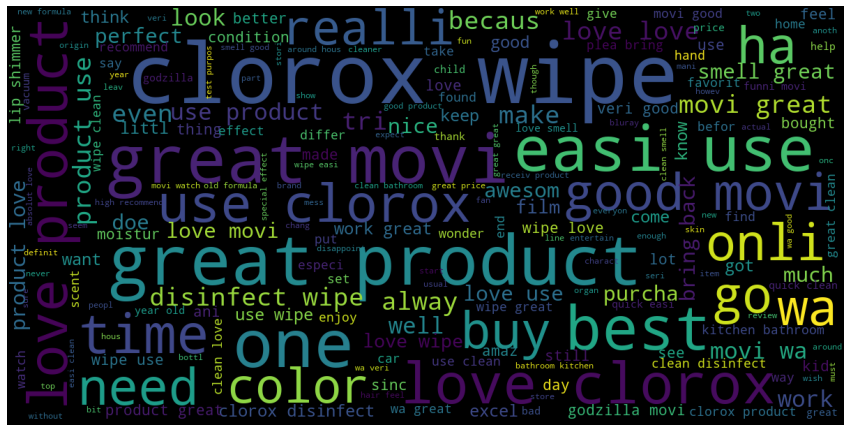

In [81]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(prdf['review_processed'])

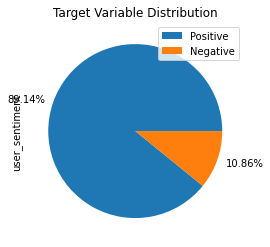

In [82]:
# Plotting for Target variable - 'user_sentiment'
test = prdf['user_sentiment'].value_counts(normalize=True)
target_data = round(test*100, 2)
target_data.index = [f"{target_data.values[0]}%", f"{target_data.values[1]}%"]
target_data.plot.pie(labels=target_data.index, title='Target Variable Distribution')
plt.legend(labels=test.index)
plt.show()

*** Rating distribution ***
5    18080
4    5200 
3    1086 
1    838  
2    288  
Name: rating, dtype: int64


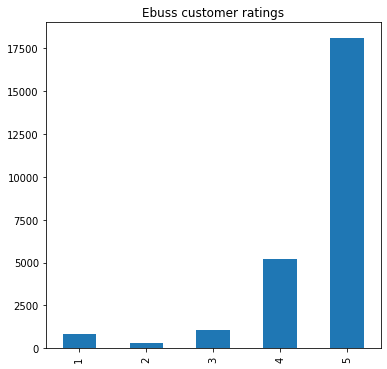

In [83]:
star = prdf.rating.value_counts()
print("*** Rating distribution ***")
print(star)
star.sort_index(inplace=True)
star.plot(kind='bar',title='Ebuss customer ratings',figsize=(6,6),style='Solarize_Light2')

In [84]:
NPS_score = round (100*((star.loc[5])-sum(star.loc[1:3]))/sum(star.loc[:]),2)
print (" NPS score of Ebuss Reviews is : "  + str(NPS_score))

 NPS score of Ebuss Reviews is : 62.25


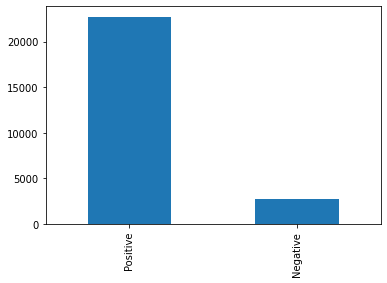

In [85]:
prdf["user_sentiment"].value_counts().plot.bar()

In [86]:
# Let's have an interger version of user_sentiment to build models
prdf['sentiment'] = prdf['user_sentiment'].apply(lambda t:1 if t=='Positive' else 0)

In [87]:
X=prdf['review_processed'].copy()
y=prdf['sentiment'].copy()

In [88]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=101)

In [89]:
X_train = ["".join(i) for i in X_train]
len(X_train)

17844

In [90]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1,1),
    max_features=30000)

word_vectorizer.fit(X_train)

X_train = word_vectorizer.transform(X_train)

In [91]:
import pickle
filename1 = 'word_vectorizer.pkl'
pickle.dump(word_vectorizer, open(filename1, 'wb'))

In [92]:
X_test = ["".join(i) for i in X_test]
X_test = word_vectorizer.transform(X_test)

In [93]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (17844, 10875)
y_train (17844,)
X_test (7648, 10875)
y_test (7648,)


In [94]:
#Over_Sampling

oversample = RandomOverSampler(random_state=777)
# fit and apply the transform
print('Before Random over-sampling:', Counter(y_train))

X_over_train, y_over_train = oversample.fit_resample(X_train, y_train)

# summarize class distribution
print('After Random over-sampling', Counter(y_over_train))

Before Random over-sampling: Counter({1: 15897, 0: 1947})
After Random over-sampling Counter({1: 15897, 0: 15897})


In [95]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=777)

print('Before Sampling:', Counter(y_train))

X_smote_train, y_smote_train = sm.fit_resample(X_train, y_train)

# summarize class distribution
print('After Sampling:', Counter(y_smote_train))

Before Sampling: Counter({1: 15897, 0: 1947})
After Sampling: Counter({1: 15897, 0: 15897})


In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import RepeatedStratifiedKFold

In [97]:
# LogisticRegression with original train data with balancing technique using class_weight parameter
lr_bal = LogisticRegression(class_weight='balanced')
lr_bal.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [98]:
pred_lr_bal = lr_bal.predict(X_test)

accuracy_lr_bal = accuracy_score(pred_lr_bal, y_test)
auc_lr_bal = roc_auc_score(y_test, pred_lr_bal)
confusion_lr_bal = metrics.confusion_matrix(y_test, pred_lr_bal)
f1_score_lr_bal = metrics.f1_score(y_test, pred_lr_bal)

TP = confusion_lr_bal[1, 1] # true positive 
TN = confusion_lr_bal[0, 0] # true negatives
FP = confusion_lr_bal[0, 1] # false positives
FN = confusion_lr_bal[1, 0] # false negatives

sensitivity_lr_bal = round((TP / float(TP+FN)), 4)
specificity_lr_bal = round((TN / float(TN+FP)), 4)
precision_lr_bal = round((TP / float(TP+FP)), 4)

print('Logistics Regression with Class_Weight:balanced Metrics:')
print('--------------------------------------------------------')
print("Accuracy:\t\t", accuracy_lr_bal)
print("ROC-AUC Score:\t\t", auc_lr_bal)
print("F1-Score\t\t", f1_score_lr_bal)
print('Precision:\t\t', precision_lr_bal)
print('Sensitivity/Recall:\t', sensitivity_lr_bal)
print('Specificity:\t\t', specificity_lr_bal)

Logistics Regression with Class_Weight:balanced Metrics:
--------------------------------------------------------
Accuracy:		 0.8470188284518828
ROC-AUC Score:		 0.7976632212743175
F1-Score		 0.9094287041337669
Precision:		 0.9642
Sensitivity/Recall:	 0.8605
Specificity:		 0.7348


In [99]:
# LogisitcRegression model using RandomOverSampling balancing technique
lr_ro = LogisticRegression()
lr_ro.fit(X_over_train, y_over_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [100]:
pred_lr_ro = lr_ro.predict(X_test)

accuracy_lr_ro = accuracy_score(pred_lr_ro, y_test)
auc_lr_ro = roc_auc_score(y_test, pred_lr_ro)
confusion_lr_ro = metrics.confusion_matrix(y_test, pred_lr_ro)
f1_score_lr_ro = metrics.f1_score(y_test, pred_lr_ro)

TP = confusion_lr_ro[1, 1] # true positive 
TN = confusion_lr_ro[0, 0] # true negatives
FP = confusion_lr_ro[0, 1] # false positives
FN = confusion_lr_ro[1, 0] # false negatives

sensitivity_lr_ro = round((TP / float(TP+FN)), 4)
specificity_lr_ro = round((TN / float(TN+FP)), 4)
precision_lr_ro = round((TP / float(TP+FP)), 4)

print('Logistics Regression with RandomOverSampling Metrics:')
print('-----------------------------------------------------')
print("Accuracy:\t\t", accuracy_lr_ro)
print("ROC-AUC Score:\t\t", auc_lr_ro)
print("F1-Score\t\t", f1_score_lr_ro)
print('Precision:\t\t', precision_lr_ro)
print('Sensitivity/Recall:\t', sensitivity_lr_ro)
print('Specificity:\t\t', specificity_lr_ro)

Logistics Regression with RandomOverSampling Metrics:
-----------------------------------------------------
Accuracy:		 0.8538179916317992
ROC-AUC Score:		 0.7950519090097046
F1-Score		 0.9139602893643219
Precision:		 0.9627
Sensitivity/Recall:	 0.8699
Specificity:		 0.7202


In [101]:
# LogisitcRegression model using SMOTE balancing technique
lr_sm = LogisticRegression()
lr_sm.fit(X_smote_train, y_smote_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [102]:
pred_lr_sm = lr_sm.predict(X_test)

accuracy_lr_sm = accuracy_score(pred_lr_sm, y_test)
auc_lr_sm = roc_auc_score(y_test, pred_lr_sm)
confusion_lr_sm = metrics.confusion_matrix(y_test, pred_lr_sm)
f1_Score_lr_sm = metrics.f1_score(y_test, pred_lr_sm)

TP = confusion_lr_sm[1, 1] # true positive 
TN = confusion_lr_sm[0, 0] # true negatives
FP = confusion_lr_sm[0, 1] # false positives
FN = confusion_lr_sm[1, 0] # false negatives

sensitivity_lr_sm = round((TP / float(TP+FN)), 4)
specificity_lr_sm = round((TN / float(TN+FP)), 4)
precision_lr_sm = round((TP / float(TP+FP)), 4)

print('Logistics Regression with SMOTE Metrics:')
print('----------------------------------------')

print("Accuracy:\t\t", accuracy_lr_sm)
print("ROC-AUC Score:\t\t", auc_lr_sm)
print("F1-Score\t\t", f1_Score_lr_sm)
print('Precision:\t\t', precision_lr_sm)
print('Sensitivity/Recall:\t', sensitivity_lr_sm)
print('Specificity:\t\t', specificity_lr_sm)

Logistics Regression with SMOTE Metrics:
----------------------------------------
Accuracy:		 0.859178870292887
ROC-AUC Score:		 0.7916348539967764
F1-Score		 0.9175281415116012
Precision:		 0.9612
Sensitivity/Recall:	 0.8777
Specificity:		 0.7056


In [103]:
# RandomForestClassifier with class_weight balancing on original train data
rf_bal = RandomForestClassifier(class_weight='balanced')
rf_bal.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [104]:
pred_rf_bal = rf_bal.predict(X_test)

accuracy_rf_bal = accuracy_score(pred_rf_bal, y_test)
auc_rf_bal = roc_auc_score(y_test, pred_rf_bal)
confusion_rf_bal = metrics.confusion_matrix(y_test, pred_rf_bal)
f1_score_rf_bal = metrics.f1_score(y_test, pred_rf_bal)

TP = confusion_rf_bal[1, 1] # true positive 
TN = confusion_rf_bal[0, 0] # true negatives
FP = confusion_rf_bal[0, 1] # false positives
FN = confusion_rf_bal[1, 0] # false negatives

sensitivity_rf_bal = round((TP / float(TP+FN)), 4)
specificity_rf_bal = round((TN / float(TN+FP)), 4)
precision_rf_bal = round((TP / float(TP+FP)), 4)

print('RandomForest with Class_weight balancing Metrics:')
print('-------------------------------------------------')
print("Accuracy:\t\t", accuracy_rf_bal)
print("ROC-AUC Score:\t\t", auc_rf_bal)
print("F1-Score\t\t", f1_score_rf_bal)
print('Precision:\t\t', precision_rf_bal)
print('Sensitivity/Recall:\t', sensitivity_rf_bal)
print('Specificity:\t\t', specificity_rf_bal)

RandomForest with Class_weight balancing Metrics:
-------------------------------------------------
Accuracy:		 0.9050732217573222
ROC-AUC Score:		 0.5771199713703793
F1-Score		 0.9492591557170813
Precision:		 0.9076
Sensitivity/Recall:	 0.9949
Specificity:		 0.1594


In [105]:
# RandomForestClassifier with RandomOverSampling balance technique
rf_ro = RandomForestClassifier()
rf_ro.fit(X_over_train, y_over_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [106]:
pred_rf_ro = rf_ro.predict(X_test)

accuracy_rf_ro = accuracy_score(pred_rf_ro, y_test)
auc_rf_ro = roc_auc_score(y_test, pred_rf_ro)
confusion_rf_ro = metrics.confusion_matrix(y_test, pred_rf_ro)
f1_score_rf_ro = metrics.f1_score(y_test, pred_rf_ro)

TP = confusion_rf_ro[1, 1] # true positive 
TN = confusion_rf_ro[0, 0] # true negatives
FP = confusion_rf_ro[0, 1] # false positives
FN = confusion_rf_ro[1, 0] # false negatives

sensitivity_rf_ro = round((TP / float(TP+FN)), 4)
specificity_rf_ro = round((TN / float(TN+FP)), 4)
precision_rf_ro = round((TP / float(TP+FP)), 4)

print('Random Forest with RandomOverSampling Metrics:')
print('----------------------------------------------')
print("Accuracy:\t\t", accuracy_rf_ro)
print("ROC-AUC Score:\t\t", auc_rf_ro)
print("F1-Score\t\t", f1_score_rf_ro)
print('Precision:\t\t', precision_rf_ro)
print('Sensitivity/Recall:\t', sensitivity_rf_ro)
print('Specificity:\t\t', specificity_rf_ro)

Random Forest with RandomOverSampling Metrics:
----------------------------------------------
Accuracy:		 0.9087343096234309
ROC-AUC Score:		 0.6257179682949763
F1-Score		 0.9507131761050698
Precision:		 0.9177
Sensitivity/Recall:	 0.9862
Specificity:		 0.2652


In [107]:
# RandomForestClassifier with SMOTE balance technique
rf_sm = RandomForestClassifier()
rf_sm.fit(X_smote_train, y_smote_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [108]:
pred_rf_sm = rf_sm.predict(X_test)

accuracy_rf_sm = accuracy_score(pred_rf_sm, y_test)
auc_rf_sm = roc_auc_score(y_test, pred_rf_sm)
confusion_rf_sm = metrics.confusion_matrix(y_test, pred_rf_sm)
f1_score_rf_sm = metrics.f1_score(y_test, pred_rf_sm)

TP = confusion_rf_sm[1, 1] # true positive 
TN = confusion_rf_sm[0, 0] # true negatives
FP = confusion_rf_sm[0, 1] # false positives
FN = confusion_rf_sm[1, 0] # false negatives

sensitivity_rf_sm = round((TP / float(TP+FN)), 4)
specificity_rf_sm = round((TN / float(TN+FP)), 4)
precision_rf_sm = round((TP / float(TP+FP)), 4)

print('Random Forest with SMOTE Metrics:')
print('---------------------------------')
print("Accuracy:\t\t", accuracy_rf_sm)
print("ROC-AUC Score:\t\t", auc_rf_sm)
print("F1-Score\t\t", f1_score_rf_sm)
print('Precision:\t\t', precision_rf_sm)
print('Sensitivity/Recall:\t', sensitivity_rf_sm)
print('Specificity:\t\t', specificity_rf_sm)

Random Forest with SMOTE Metrics:
---------------------------------
Accuracy:		 0.8935669456066946
ROC-AUC Score:		 0.6386219713803597
F1-Score		 0.9417155950164685
Precision:		 0.921
Sensitivity/Recall:	 0.9634
Specificity:		 0.3139


In [109]:
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 0.122


In [110]:
# XGBClassifier with SCALE_POS_WEIGHT class balance parameter on original train data
xgb_spw=xgb.XGBClassifier(scale_pos_weight=0.122, n_jobs=-1, nthread=4)
xgb_spw.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.122, seed=None,
              silent=None, subsample=1, verbosity=1)

In [111]:
pred_xgb_spw = xgb_spw.predict(X_test)

accuracy_xgb_spw = accuracy_score(pred_xgb_spw, y_test)
auc_xgb_spw = roc_auc_score(y_test, pred_xgb_spw)
confusion_xgb_spw = metrics.confusion_matrix(y_test, pred_xgb_spw)
f1_score_xgb_spw = metrics.f1_score(y_test, pred_xgb_spw)

TP = confusion_xgb_spw[1, 1] # true positive 
TN = confusion_xgb_spw[0, 0] # true negatives
FP = confusion_xgb_spw[0, 1] # false positives
FN = confusion_xgb_spw[1, 0] # false negatives

sensitivity_xgb_spw = round((TP / float(TP+FN)), 4)
specificity_xgb_spw = round((TN / float(TN+FP)), 4)
precision_xgb_spw = round((TP / float(TP+FP)), 4)

print('XGBooster with SCALE_POS_WEIGHT Sampling Metrics:')
print('-------------------------------------------------')
print("Accuracy:\t\t", accuracy_xgb_spw)
print("ROC-AUC Score:\t\t", auc_xgb_spw)
print("F1-Score\t\t", f1_score_xgb_spw)
print('Precision:\t\t', precision_xgb_spw)
print('Sensitivity/Recall:\t', sensitivity_xgb_spw)
print('Specificity:\t\t', specificity_xgb_spw)

XGBooster with SCALE_POS_WEIGHT Sampling Metrics:
-------------------------------------------------
Accuracy:		 0.7792887029288703
ROC-AUC Score:		 0.7736306650612408
F1-Score		 0.8632977000323939
Precision:		 0.9652
Sensitivity/Recall:	 0.7808
Specificity:		 0.7664


In [112]:
# XGBClassifier with RandomOverSampling balance technique
xgb_ro=xgb.XGBClassifier(n_jobs=-1, nthread=4)
xgb_ro.fit(X_over_train, y_over_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [113]:
pred_xgb_ro = xgb_ro.predict(X_test)

accuracy_xgb_ro = accuracy_score(pred_xgb_ro, y_test)
auc_xgb_ro = roc_auc_score(y_test, pred_xgb_ro)
confusion_xgb_ro = metrics.confusion_matrix(y_test, pred_xgb_ro)
f1_score_xgb_ro = metrics.f1_score(y_test, pred_xgb_ro)

TP = confusion_xgb_ro[1, 1] # true positive 
TN = confusion_xgb_ro[0, 0] # true negatives
FP = confusion_xgb_ro[0, 1] # false positives
FN = confusion_xgb_ro[1, 0] # false negatives

sensitivity_xgb_ro = round((TP / float(TP+FN)), 4)
specificity_xgb_ro = round((TN / float(TN+FP)), 4)
precision_xgb_ro = round((TP / float(TP+FP)), 4)

print('XGBooster with RandomOverSampling Metrics:')
print('------------------------------------------')
print("Accuracy:\t\t", accuracy_xgb_ro)
print("ROC-AUC Score:\t\t", auc_xgb_ro)
print("F1-Score\t\t", f1_score_xgb_ro)
print('Precision:\t\t', precision_xgb_ro)
print('Sensitivity/Recall:\t', sensitivity_xgb_ro)
print('Specificity:\t\t', specificity_xgb_ro)

XGBooster with RandomOverSampling Metrics:
------------------------------------------
Accuracy:		 0.7744508368200836
ROC-AUC Score:		 0.7794808100984999
F1-Score		 0.8595162472514049
Precision:		 0.9677
Sensitivity/Recall:	 0.7731
Specificity:		 0.7859


In [114]:
# XGBClassifier with SMOTE balancing technique
xgb_sm=xgb.XGBClassifier(n_jobs=-1, nthread=4)
xgb_sm.fit(X_smote_train, y_smote_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [115]:
pred_xgb_sm = xgb_sm.predict(X_test)

accuracy_xgb_sm = accuracy_score(pred_xgb_sm, y_test)
auc_xgb_sm = roc_auc_score(y_test, pred_xgb_sm)
confusion_xgb_sm = metrics.confusion_matrix(y_test, pred_xgb_sm)
f1_score_xgb_sm = metrics.f1_score(y_test, pred_xgb_sm)

TP = confusion_xgb_sm[1, 1] # true positive 
TN = confusion_xgb_sm[0, 0] # true negatives
FP = confusion_xgb_sm[0, 1] # false positives
FN = confusion_xgb_sm[1, 0] # false negatives

sensitivity_xgb_sm = round((TP / float(TP+FN)), 4)
specificity_xgb_sm = round((TN / float(TN+FP)), 4)
precision_xgb_sm = round((TP / float(TP+FP)), 4)

print('XGBooster with SMOTE Metrics:')
print('-----------------------------')
print("Accuracy:\t\t", accuracy_xgb_sm)
print("ROC-AUC Score:\t\t", auc_xgb_sm)
print("F1-Score\t\t", f1_score_xgb_sm)
print('Precision:\t\t', precision_xgb_sm)
print('Sensitivity/Recall:\t', sensitivity_xgb_sm)
print('Specificity:\t\t', specificity_xgb_sm)

XGBooster with SMOTE Metrics:
-----------------------------
Accuracy:		 0.8407426778242678
ROC-AUC Score:		 0.7005181989858441
F1-Score		 0.9078668683812406
Precision:		 0.9385
Sensitivity/Recall:	 0.8791
Specificity:		 0.5219


In [116]:
params = {
        'learning_rate': [0.1, 0.2, 0.4],
        'max_depth': [3, 5, 10],
        'n_estimators': [100, 150, 200]
        }

xgb_cv_ro_1=xgb.XGBClassifier(n_jobs=-1, nthread=4)

random_search_xgb_cv_ro_1 = RandomizedSearchCV(xgb_cv_ro_1, 
                            param_distributions=params, 
                            n_iter=5, 
                            scoring='accuracy',
                            cv=3,
                            verbose=3)

random_search_xgb_cv_ro_1.fit(X_over_train, y_over_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_estimators=100, max_depth=10, learning_rate=0.2 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, max_depth=10, learning_rate=0.2, score=0.947, total=  12.4s
[CV] n_estimators=100, max_depth=10, learning_rate=0.2 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s


[CV]  n_estimators=100, max_depth=10, learning_rate=0.2, score=0.946, total=  12.2s
[CV] n_estimators=100, max_depth=10, learning_rate=0.2 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   24.6s remaining:    0.0s


[CV]  n_estimators=100, max_depth=10, learning_rate=0.2, score=0.941, total=  12.3s
[CV] n_estimators=200, max_depth=5, learning_rate=0.1 ................
[CV]  n_estimators=200, max_depth=5, learning_rate=0.1, score=0.898, total=  12.4s
[CV] n_estimators=200, max_depth=5, learning_rate=0.1 ................
[CV]  n_estimators=200, max_depth=5, learning_rate=0.1, score=0.905, total=  12.7s
[CV] n_estimators=200, max_depth=5, learning_rate=0.1 ................
[CV]  n_estimators=200, max_depth=5, learning_rate=0.1, score=0.897, total=  12.3s
[CV] n_estimators=100, max_depth=5, learning_rate=0.1 ................
[CV]  n_estimators=100, max_depth=5, learning_rate=0.1, score=0.867, total=   6.3s
[CV] n_estimators=100, max_depth=5, learning_rate=0.1 ................
[CV]  n_estimators=100, max_depth=5, learning_rate=0.1, score=0.874, total=   6.3s
[CV] n_estimators=100, max_depth=5, learning_rate=0.1 ................
[CV]  n_estimators=100, max_depth=5, learning_rate=0.1, score=0.868, total=

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=4,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='depr

In [117]:
xgb_cv_ro_1_best=random_search_xgb_cv_ro_1.best_estimator_
pred_xgb_cv_ro_1_best=xgb_cv_ro_1_best.predict(X_test)

accuracy_xgb_cv_ro_1_best=accuracy_score(pred_xgb_cv_ro_1_best, y_test)
auc_xgb_cv_ro_1_best = roc_auc_score(y_test, pred_xgb_cv_ro_1_best)
confusion_xgb_cv_ro_1_best = metrics.confusion_matrix(y_test, pred_xgb_cv_ro_1_best)
f1_score_xgb_cv_ro_1_best = metrics.f1_score(y_test, pred_xgb_cv_ro_1_best)

TP = confusion_xgb_cv_ro_1_best[1, 1] # true positive 
TN = confusion_xgb_cv_ro_1_best[0, 0] # true negatives
FP = confusion_xgb_cv_ro_1_best[0, 1] # false positives
FN = confusion_xgb_cv_ro_1_best[1, 0] # false negatives

sensitivity_xgb_cv_ro_1_best = round((TP / float(TP+FN)), 4)
specificity_xgb_cv_ro_1_best = round((TN / float(TN+FP)), 4)
precision_xgb_cv_ro_1_best = round((TP / float(TP+FP)), 4)

print('XGBooster with RandomOverSampling and Hyper-Parameter Tuning - 1:')
print('----------------------------------------------------------------')
print('Params:\t\t', random_search_xgb_cv_ro_1.best_params_)
print("Accuracy:\t\t", accuracy_xgb_cv_ro_1_best)
print('ROC-AUC Score:\t\t', auc_xgb_cv_ro_1_best)
print("F1-Score\t\t", f1_score_xgb_cv_ro_1_best)
print('Precision:\t\t', precision_xgb_cv_ro_1_best)
print('Sensitivity/Recall:\t', sensitivity_xgb_cv_ro_1_best)
print('Specificity:\t\t', specificity_xgb_cv_ro_1_best)

XGBooster with RandomOverSampling and Hyper-Parameter Tuning - 1:
----------------------------------------------------------------
Params:		 {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2}
Accuracy:		 0.8823221757322176
ROC-AUC Score:		 0.7660783194070475
F1-Score		 0.9327354260089686
Precision:		 0.9521
Sensitivity/Recall:	 0.9142
Specificity:		 0.618


In [118]:
params = {
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [5, 10, 20],
        'n_estimators': [150, 200, 300]
        }

xgb_cv_ro_2=xgb.XGBClassifier(n_jobs=-1)

random_search_xgb_cv_ro_2 = RandomizedSearchCV(xgb_cv_ro_2, 
                            param_distributions=params, 
                            n_iter=5, 
                            scoring='accuracy',
                            cv=3,
                            verbose=3)

random_search_xgb_cv_ro_2.fit(X_over_train, y_over_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_estimators=150, max_depth=10, colsample_bytree=0.8 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=150, max_depth=10, colsample_bytree=0.8, score=0.938, total=  15.4s
[CV] n_estimators=150, max_depth=10, colsample_bytree=0.8 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.4s remaining:    0.0s


[CV]  n_estimators=150, max_depth=10, colsample_bytree=0.8, score=0.939, total=  15.3s
[CV] n_estimators=150, max_depth=10, colsample_bytree=0.8 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   30.7s remaining:    0.0s


[CV]  n_estimators=150, max_depth=10, colsample_bytree=0.8, score=0.934, total=  15.4s
[CV] n_estimators=200, max_depth=20, colsample_bytree=0.8 ............
[CV]  n_estimators=200, max_depth=20, colsample_bytree=0.8, score=0.965, total=  38.6s
[CV] n_estimators=200, max_depth=20, colsample_bytree=0.8 ............
[CV]  n_estimators=200, max_depth=20, colsample_bytree=0.8, score=0.968, total=  38.6s
[CV] n_estimators=200, max_depth=20, colsample_bytree=0.8 ............
[CV]  n_estimators=200, max_depth=20, colsample_bytree=0.8, score=0.963, total=  38.5s
[CV] n_estimators=200, max_depth=10, colsample_bytree=0.8 ............
[CV]  n_estimators=200, max_depth=10, colsample_bytree=0.8, score=0.942, total=  20.0s
[CV] n_estimators=200, max_depth=10, colsample_bytree=0.8 ............
[CV]  n_estimators=200, max_depth=10, colsample_bytree=0.8, score=0.946, total=  20.1s
[CV] n_estimators=200, max_depth=10, colsample_bytree=0.8 ............
[CV]  n_estimators=200, max_depth=10, colsample_bytr

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  5.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='d

In [119]:
xgb_cv_ro_2_best=random_search_xgb_cv_ro_2.best_estimator_
pred_xgb_cv_ro_2_best=xgb_cv_ro_2_best.predict(X_test)

accuracy_xgb_cv_ro_2_best=accuracy_score(pred_xgb_cv_ro_2_best, y_test)
auc_xgb_cv_ro_2_best = roc_auc_score(y_test, pred_xgb_cv_ro_2_best)
confusion_xgb_cv_ro_2_best = metrics.confusion_matrix(y_test, pred_xgb_cv_ro_2_best)
f1_score_xgb_cv_ro_2_best = metrics.f1_score(y_test, pred_xgb_cv_ro_2_best)

TP = confusion_xgb_cv_ro_2_best[1, 1] # true positive 
TN = confusion_xgb_cv_ro_2_best[0, 0] # true negatives
FP = confusion_xgb_cv_ro_2_best[0, 1] # false positives
FN = confusion_xgb_cv_ro_2_best[1, 0] # false negatives

sensitivity_xgb_cv_ro_2_best = round((TP / float(TP+FN)), 4)
specificity_xgb_cv_ro_2_best = round((TN / float(TN+FP)), 4)
precision_xgb_cv_ro_2_best = round((TP / float(TP+FP)), 4)

print('XGBooster with RandomOverSampling and Hyper-Parameter Tuning - 2:')
print('----------------------------------------------------------------')
print('Params:\t\t', random_search_xgb_cv_ro_2.best_params_)
print("Accuracy:\t\t", accuracy_xgb_cv_ro_2_best)
print('ROC-AUC Score:\t\t', auc_xgb_cv_ro_2_best)
print("F1-Score\t\t", f1_score_xgb_cv_ro_2_best)
print('Precision:\t\t', precision_xgb_cv_ro_2_best)
print('Sensitivity/Recall:\t', sensitivity_xgb_cv_ro_2_best)
print('Specificity:\t\t', specificity_xgb_cv_ro_2_best)

XGBooster with RandomOverSampling and Hyper-Parameter Tuning - 2:
----------------------------------------------------------------
Params:		 {'n_estimators': 200, 'max_depth': 20, 'colsample_bytree': 0.8}
Accuracy:		 0.9035041841004184
ROC-AUC Score:		 0.7276525350687902
F1-Score		 0.9462490895848508
Precision:		 0.9409
Sensitivity/Recall:	 0.9517
Specificity:		 0.5036


In [120]:
params = {
        'scale_pos_weight': [0.1, 0.122, 0.15],
        'max_depth': [4, 5], 
        'learning_rate': [0.1, 0.2],
        'n_estimators': [150, 200]
        }
xgb_cv_spw_1=xgb.XGBClassifier(n_jobs=-1, nthread=4)

random_search_xgb_cv_spw_1 = RandomizedSearchCV(xgb_cv_spw_1, 
                                  param_distributions=params, 
                                  n_iter=5, 
                                  scoring='accuracy', 
                                  n_jobs=-1, 
                                  cv=3, 
                                  random_state=1001, 
                                  verbose=3)

random_search_xgb_cv_spw_1.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=4,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='depr

In [121]:
xgb_cv_spw_1_best=random_search_xgb_cv_spw_1.best_estimator_
pred_xgb_cv_spw_1_best=xgb_cv_spw_1_best.predict(X_test)

accuracy_xgb_cv_spw_1_best=accuracy_score(pred_xgb_cv_spw_1_best, y_test)
auc_xgb_cv_spw_1_best = roc_auc_score(y_test, pred_xgb_cv_spw_1_best)
confusion_xgb_cv_spw_1_best = metrics.confusion_matrix(y_test, pred_xgb_cv_spw_1_best)
f1_score_xgb_cv_spw_1_best = metrics.f1_score(y_test, pred_xgb_cv_spw_1_best)

TP = confusion_xgb_cv_spw_1_best[1, 1] # true positive 
TN = confusion_xgb_cv_spw_1_best[0, 0] # true negatives
FP = confusion_xgb_cv_spw_1_best[0, 1] # false positives
FN = confusion_xgb_cv_spw_1_best[1, 0] # false negatives

sensitivity_xgb_cv_spw_1_best = round((TP / float(TP+FN)), 4)
specificity_xgb_cv_spw_1_best = round((TN / float(TN+FP)), 4)
precision_xgb_cv_spw_1_best = round((TP / float(TP+FP)), 4)

print('XGBooster with SPACE_POS_WEIGHT and HyperParameter Tuning - 1 Metrics:')
print('----------------------------------------------------------------------')
print('Params:\t\t', random_search_xgb_cv_spw_1.best_params_)
print("Accuracy:\t\t", accuracy_xgb_cv_spw_1_best)
print('ROC-AUC Score:\t\t', auc_xgb_cv_spw_1_best)
print("F1-Score\t\t", f1_score_xgb_cv_spw_1_best)
print('Precision:\t\t', precision_xgb_cv_spw_1_best)
print('Sensitivity/Recall:\t', sensitivity_xgb_cv_spw_1_best)
print('Specificity:\t\t', specificity_xgb_cv_spw_1_best)

XGBooster with SPACE_POS_WEIGHT and HyperParameter Tuning - 1 Metrics:
----------------------------------------------------------------------
Params:		 {'scale_pos_weight': 0.15, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2}
Accuracy:		 0.8676778242677824
ROC-AUC Score:		 0.7926508989886244
F1-Score		 0.9229715329578322
Precision:		 0.9606
Sensitivity/Recall:	 0.8882
Specificity:		 0.6971


In [122]:
params = {
        'scale_pos_weight': [0.12, 0.15, 0.18],
        'max_depth': [4, 5],
        'learning_rate': [0.2, 0.25, 0.28],
        'n_estimators': [125, 150]
        }
xgb_cv_spw_2=xgb.XGBClassifier(n_jobs=-1, nthread=4)

random_search_xgb_cv_spw_2 = RandomizedSearchCV(xgb_cv_spw_2, param_distributions=params, n_iter=10, scoring='accuracy', 
                                   n_jobs=-1, cv=3, random_state=1001, verbose=2 )

random_search_xgb_cv_spw_2.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=4,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='depr

In [123]:
xgb_cv_spw_2_best=random_search_xgb_cv_spw_2.best_estimator_
pred_xgb_cv_spw_2_best=xgb_cv_spw_2_best.predict(X_test)

accuracy_xgb_cv_spw_2_best=accuracy_score(pred_xgb_cv_spw_2_best, y_test)
auc_xgb_cv_spw_2_best = roc_auc_score(y_test, pred_xgb_cv_spw_2_best)
confusion_xgb_cv_spw_2_best = metrics.confusion_matrix(y_test, pred_xgb_cv_spw_2_best)
f1_score_xgb_cv_spw_2_best = metrics.f1_score(y_test, pred_xgb_cv_spw_2_best)

TP = confusion_xgb_cv_spw_2_best[1, 1] # true positive 
TN = confusion_xgb_cv_spw_2_best[0, 0] # true negatives
FP = confusion_xgb_cv_spw_2_best[0, 1] # false positives
FN = confusion_xgb_cv_spw_2_best[1, 0] # false negatives

sensitivity_xgb_cv_spw_2_best = round((TP / float(TP+FN)), 4)
specificity_xgb_cv_spw_2_best = round((TN / float(TN+FP)), 4)
precision_xgb_cv_spw_2_best = round((TP / float(TP+FP)), 4)

print('XGBooster with SPACE_POS_WEIGHT and HyperParameter Tuning - 2 Metrics:')
print('----------------------------------------------------------------------')
print('Params:\t\t', random_search_xgb_cv_spw_2.best_params_)
print("Accuracy:\t\t", accuracy_xgb_cv_spw_2_best)
print('ROC-AUC Score:\t\t', auc_xgb_cv_spw_2_best)
print("F1-Score\t\t", f1_score_xgb_cv_spw_2_best)
print('Precision:\t\t', precision_xgb_cv_spw_2_best)
print('Sensitivity/Recall:\t', sensitivity_xgb_cv_spw_2_best)
print('Specificity:\t\t', specificity_xgb_cv_spw_2_best)

XGBooster with SPACE_POS_WEIGHT and HyperParameter Tuning - 2 Metrics:
----------------------------------------------------------------------
Params:		 {'scale_pos_weight': 0.18, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.28}
Accuracy:		 0.8759152719665272
ROC-AUC Score:		 0.782284958827098
F1-Score		 0.9284151768876822
Precision:		 0.9569
Sensitivity/Recall:	 0.9016
Specificity:		 0.663


In [124]:
# XGBClassifier with SCALE_POS_WEIGHT Sampling with other Hyper-Parameters Tuning - 1
xgb_trial_spw_1=xgb.XGBClassifier(scale_pos_weight=0.12, n_estimators=200, max_depth=4, learning_rate=0.1,
    n_jobs=-1,
    nthread=4)

xgb_trial_spw_1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.12, seed=None,
              silent=None, subsample=1, verbosity=1)

In [125]:
pred_xgb_trial_spw_1=xgb_trial_spw_1.predict(X_test)

accuracy_xgb_trial_spw_1 = accuracy_score(pred_xgb_trial_spw_1, y_test)
auc_xgb_trial_spw_1 = roc_auc_score(y_test, pred_xgb_trial_spw_1)
confusion_xgb_trial_spw_1 = metrics.confusion_matrix(y_test, pred_xgb_trial_spw_1)
f1_score_xgb_trial_spw_1 = metrics.f1_score(y_test, pred_xgb_trial_spw_1)

TP = confusion_xgb_trial_spw_1[1, 1] # true positive 
TN = confusion_xgb_trial_spw_1[0, 0] # true negatives
FP = confusion_xgb_trial_spw_1[0, 1] # false positives
FN = confusion_xgb_trial_spw_1[1, 0] # false negatives

sensitivity_xgb_trial_spw_1 = round((TP / float(TP+FN)), 4)
specificity_xgb_trial_spw_1 = round((TN / float(TN+FP)), 4)
precision_xgb_trial_spw_1 = round((TP / float(TP+FP)), 4)

print('XGBooster with SCALE_POS_WEIGHT Sampling Manual Tuning-1 Metrics:')
print('-----------------------------------------------------------------')
print("Accuracy:\t\t", accuracy_xgb_trial_spw_1)
print("ROC-AUC Score:\t\t", auc_xgb_trial_spw_1)
print("F1-Score:\t\t", f1_score_xgb_trial_spw_1)
print('Precision:\t\t', precision_xgb_trial_spw_1)
print('Sensitivity/Recall:\t', sensitivity_xgb_trial_spw_1)
print('Specificity:\t\t', specificity_xgb_trial_spw_1)

XGBooster with SCALE_POS_WEIGHT Sampling Manual Tuning-1 Metrics:
-----------------------------------------------------------------
Accuracy:		 0.8123692468619247
ROC-AUC Score:		 0.7996530725870669
F1-Score:		 0.8858665394098464
Precision:		 0.969
Sensitivity/Recall:	 0.8159
Specificity:		 0.7835


In [126]:
# XGBClassifier with RandomOverSampling Sampling with other Hyper-Parameters Tuning - 1
xgb_trial_ro_1=xgb.XGBClassifier(n_estimators=150, max_depth=5, learning_rate=0.2,
    n_jobs=-1,
    nthread=4)

xgb_trial_ro_1.fit(X_over_train, y_over_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [127]:
pred_xgb_trial_ro_1=xgb_trial_ro_1.predict(X_test)

accuracy_xgb_trial_ro_1=accuracy_score(pred_xgb_trial_ro_1, y_test)
auc_xgb_trial_ro_1 = roc_auc_score(y_test, pred_xgb_trial_ro_1)
confusion_xgb_trial_ro_1 = metrics.confusion_matrix(y_test, pred_xgb_trial_ro_1)
f1_score_xgb_trial_ro_1 = metrics.f1_score(y_test, pred_xgb_trial_ro_1)

TP = confusion_xgb_trial_ro_1[1, 1] # true positive 
TN = confusion_xgb_trial_ro_1[0, 0] # true negatives
FP = confusion_xgb_trial_ro_1[0, 1] # false positives
FN = confusion_xgb_trial_ro_1[1, 0] # false negatives

sensitivity_xgb_trial_ro_1 = round((TP / float(TP+FN)), 4)
specificity_xgb_trial_ro_1 = round((TN / float(TN+FP)), 4)
precision_xgb_trial_ro_1 = round((TP / float(TP+FP)), 4)

print('XGBooster with RandomOverSampling Sampling Manual Tuning-1 Metrics:')
print('-------------------------------------------------------------------')
print("Accuracy:\t\t", accuracy_xgb_trial_ro_1)
print("ROC-AUC Score:\t\t", auc_xgb_trial_ro_1)
print("F1-Score:\t\t", f1_score_xgb_trial_ro_1)
print('Precision:\t\t', precision_xgb_trial_ro_1)
print('Sensitivity/Recall:\t', sensitivity_xgb_trial_ro_1)
print('Specificity:\t\t', specificity_xgb_trial_ro_1)

XGBooster with RandomOverSampling Sampling Manual Tuning-1 Metrics:
-------------------------------------------------------------------
Accuracy:		 0.8582635983263598
ROC-AUC Score:		 0.7932622012727919
F1-Score:		 0.9168966574670346
Precision:		 0.9617
Sensitivity/Recall:	 0.8761
Specificity:		 0.7105


In [128]:
print('------------------------------------------------------')
print('LogisticRegression with Class_Weight:balanced Metrics:')
print('------------------------------------------------------')
print("Accuracy:\t\t", accuracy_lr_bal)
print("ROC-AUC Score:\t\t", auc_lr_bal)
print("F1-Score\t\t", f1_score_lr_bal)
print('Precision:\t\t', precision_lr_bal)
print('Sensitivity/Recall:\t', sensitivity_lr_bal)
print('Specificity:\t\t', specificity_lr_bal)

print('---------------------------------------------------')
print('LogisticRegression with RandomOverSampling Metrics:')
print('---------------------------------------------------')
print("Accuracy:\t\t", accuracy_lr_ro)
print("ROC-AUC Score:\t\t", auc_lr_ro)
print("F1-Score\t\t", f1_score_lr_ro)
print('Precision:\t\t', precision_lr_ro)
print('Sensitivity/Recall:\t', sensitivity_lr_ro)
print('Specificity:\t\t', specificity_lr_ro)

print('--------------------------------------')
print('LogisticRegression with SMOTE Metrics:')
print('--------------------------------------')
print("Accuracy:\t\t", accuracy_lr_sm)
print("ROC-AUC Score:\t\t", auc_lr_sm)
print("F1-Score\t\t", f1_Score_lr_sm)
print('Precision:\t\t', precision_lr_sm)
print('Sensitivity/Recall:\t', sensitivity_lr_sm)
print('Specificity:\t\t', specificity_lr_sm)

print('-------------------------------------------------')
print('RandomForest with Class_weight balancing Metrics:')
print('-------------------------------------------------')
print("Accuracy:\t\t", accuracy_rf_bal)
print("ROC-AUC Score:\t\t", auc_rf_bal)
print("F1-Score\t\t", f1_score_rf_bal)
print('Precision:\t\t', precision_rf_bal)
print('Sensitivity/Recall:\t', sensitivity_rf_bal)
print('Specificity:\t\t', specificity_rf_bal)

print('---------------------------------------------')
print('RandomForest with RandomOverSampling Metrics:')
print('---------------------------------------------')
print("Accuracy:\t\t", accuracy_rf_ro)
print("ROC-AUC Score:\t\t", auc_rf_ro)
print("F1-Score\t\t", f1_score_rf_ro)
print('Precision:\t\t', precision_rf_ro)
print('Sensitivity/Recall:\t', sensitivity_rf_ro)
print('Specificity:\t\t', specificity_rf_ro)

print('--------------------------------')
print('RandomForest with SMOTE Metrics:')
print('--------------------------------')
print("Accuracy:\t\t", accuracy_rf_sm)
print("ROC-AUC Score:\t\t", auc_rf_sm)
print("F1-Score\t\t", f1_score_rf_sm)
print('Precision:\t\t', precision_rf_sm)
print('Sensitivity/Recall:\t', sensitivity_rf_sm)
print('Specificity:\t\t', specificity_rf_sm)

print('-------------------------------------------------')
print('XGBooster with SCALE_POS_WEIGHT Sampling Metrics:')
print('-------------------------------------------------')
print("Accuracy:\t\t", accuracy_xgb_spw)
print("ROC-AUC Score:\t\t", auc_xgb_spw)
print("F1-Score\t\t", f1_score_xgb_spw)
print('Precision:\t\t', precision_xgb_spw)
print('Sensitivity/Recall:\t', sensitivity_xgb_spw)
print('Specificity:\t\t', specificity_xgb_spw)

print('------------------------------------------')
print('XGBooster with RandomOverSampling Metrics:')
print('------------------------------------------')
print("Accuracy:\t\t", accuracy_xgb_ro)
print("ROC-AUC Score:\t\t", auc_xgb_ro)
print("F1-Score\t\t", f1_score_xgb_ro)
print('Precision:\t\t', precision_xgb_ro)
print('Sensitivity/Recall:\t', sensitivity_xgb_ro)
print('Specificity:\t\t', specificity_xgb_ro)

print('--------------------------------------')
print('XGBooster with SMOTE Sampling Metrics:')
print('--------------------------------------')
print("Accuracy:\t\t", accuracy_xgb_sm)
print("ROC-AUC Score:\t\t", auc_xgb_sm)
print("F1-Score\t\t", f1_score_xgb_sm)
print('Precision:\t\t', precision_xgb_sm)
print('Sensitivity/Recall:\t', sensitivity_xgb_sm)
print('Specificity:\t\t', specificity_xgb_sm)

print('-----------------------------------------------------------------')
print('XGBooster with RandomOverSampling and Hyper-Parameter Tuning - 1:')
print('-----------------------------------------------------------------')
print('Params:\t\t', random_search_xgb_cv_ro_1.best_params_)
print("Accuracy:\t\t", accuracy_xgb_cv_ro_1_best)
print('ROC-AUC Score:\t\t', auc_xgb_cv_ro_1_best)
print("F1-Score\t\t", f1_score_xgb_cv_ro_1_best)
print('Precision:\t\t', precision_xgb_cv_ro_1_best)
print('Sensitivity/Recall:\t', sensitivity_xgb_cv_ro_1_best)
print('Specificity:\t\t', specificity_xgb_cv_ro_1_best)

print('-----------------------------------------------------------------')
print('XGBooster with RandomOverSampling and Hyper-Parameter Tuning - 2:')
print('-----------------------------------------------------------------')
print('Params:\t\t', random_search_xgb_cv_ro_2.best_params_)
print("Accuracy:\t\t", accuracy_xgb_cv_ro_2_best)
print('ROC-AUC Score:\t\t', auc_xgb_cv_ro_2_best)
print("F1-Score\t\t", f1_score_xgb_cv_ro_2_best)
print('Precision:\t\t', precision_xgb_cv_ro_2_best)
print('Sensitivity/Recall:\t', sensitivity_xgb_cv_ro_2_best)
print('Specificity:\t\t', specificity_xgb_cv_ro_2_best)

print('----------------------------------------------------------------------')
print('XGBooster with SPACE_POS_WEIGHT and HyperParameter Tuning - 1 Metrics:')
print('----------------------------------------------------------------------')
print('Params:\t\t', random_search_xgb_cv_spw_1.best_params_)
print("Accuracy:\t\t", accuracy_xgb_cv_spw_1_best)
print('ROC-AUC Score:\t\t', auc_xgb_cv_spw_1_best)
print("F1-Score\t\t", f1_score_xgb_cv_spw_1_best)
print('Precision:\t\t', precision_xgb_cv_spw_1_best)
print('Sensitivity/Recall:\t', sensitivity_xgb_cv_spw_1_best)
print('Specificity:\t\t', specificity_xgb_cv_spw_1_best)

print('----------------------------------------------------------------------')
print('XGBooster with SPACE_POS_WEIGHT and HyperParameter Tuning - 2 Metrics:')
print('----------------------------------------------------------------------')
print('Params:\t\t', random_search_xgb_cv_spw_2.best_params_)
print("Accuracy:\t\t", accuracy_xgb_cv_spw_2_best)
print('ROC-AUC Score:\t\t', auc_xgb_cv_spw_2_best)
print("F1-Score\t\t", f1_score_xgb_cv_spw_2_best)
print('Precision:\t\t', precision_xgb_cv_spw_2_best)
print('Sensitivity/Recall:\t', sensitivity_xgb_cv_spw_2_best)
print('Specificity:\t\t', specificity_xgb_cv_spw_2_best)

print('-----------------------------------------------------------------')
print('XGBooster with SCALE_POS_WEIGHT Sampling Manual Tuning-1 Metrics:')
print('-----------------------------------------------------------------')
print("Accuracy:\t\t", accuracy_xgb_trial_spw_1)
print("ROC-AUC Score:\t\t", auc_xgb_trial_spw_1)
print("F1-Score:\t\t", f1_score_xgb_trial_spw_1)
print('Precision:\t\t', precision_xgb_trial_spw_1)
print('Sensitivity/Recall:\t', sensitivity_xgb_trial_spw_1)
print('Specificity:\t\t', specificity_xgb_trial_spw_1)

print('-------------------------------------------------------------------')
print('XGBooster with RandomOverSampling Sampling Manual Tuning-1 Metrics:')
print('-------------------------------------------------------------------')
print("Accuracy:\t\t", accuracy_xgb_trial_ro_1)
print("ROC-AUC Score:\t\t", auc_xgb_trial_ro_1)
print("F1-Score:\t\t", f1_score_xgb_trial_ro_1)
print('Precision:\t\t', precision_xgb_trial_ro_1)
print('Sensitivity/Recall:\t', sensitivity_xgb_trial_ro_1)
print('Specificity:\t\t', specificity_xgb_trial_ro_1)

------------------------------------------------------
LogisticRegression with Class_Weight:balanced Metrics:
------------------------------------------------------
Accuracy:		 0.8470188284518828
ROC-AUC Score:		 0.7976632212743175
F1-Score		 0.9094287041337669
Precision:		 0.9642
Sensitivity/Recall:	 0.8605
Specificity:		 0.7348
---------------------------------------------------
LogisticRegression with RandomOverSampling Metrics:
---------------------------------------------------
Accuracy:		 0.8538179916317992
ROC-AUC Score:		 0.7950519090097046
F1-Score		 0.9139602893643219
Precision:		 0.9627
Sensitivity/Recall:	 0.8699
Specificity:		 0.7202
--------------------------------------
LogisticRegression with SMOTE Metrics:
--------------------------------------
Accuracy:		 0.859178870292887
ROC-AUC Score:		 0.7916348539967764
F1-Score		 0.9175281415116012
Precision:		 0.9612
Sensitivity/Recall:	 0.8777
Specificity:		 0.7056
-------------------------------------------------
RandomForest

<table align="left">
  <tr>
    <th style="text-align:left">Model No</th>
    <th style="text-align:left" width=400>Models</th>
    <th style="text-align:left">Accuracy</th>
    <th style="text-align:left">ROC-AUC</th>
    <th style="text-align:left">F1-Score</th>
    <th style="text-align:left">Precision</th>
    <th style="text-align:left">Sensitivity/Recall</th>
    <th style="text-align:left">Specificity</th>
    <th style="text-align:left">Params</th>
  </tr>
  <tr>
    <td style="text-align:left">M1</td>
    <td style="text-align:left">LogisticRegression with class_weight - balanced</td>
    <td style="text-align:left">84.7</td> 
    <td style="text-align:left">79.76</td>
    <td style="text-align:left">90.94</td> 
    <td style="text-align:left">96.42</td>
    <td style="text-align:left">86.05</td> 
    <td style="text-align:left">73.48</td>
    <td style="text-align:left"></td>
  </tr>
  <tr>
    <td style="text-align:left">M2</td>
    <td style="text-align:left">LogisticRegression with RandomOverSampling</td>
    <td style="text-align:left">85.38</td> 
    <td style="text-align:left">79.51</td>
    <td style="text-align:left">91.39</td> 
    <td style="text-align:left">96.27</td>
    <td style="text-align:left">86.99</td> 
    <td style="text-align:left">72.02</td>
    <td style="text-align:left"></td>
  </tr>
  <tr>
    <td style="text-align:left">M3</td>
    <td style="text-align:left">LogisticRegression with SMOTE</td>
    <td style="text-align:left">85.91</td> 
    <td style="text-align:left">79.16</td>
    <td style="text-align:left">91.75</td> 
    <td style="text-align:left">96.12</td>
    <td style="text-align:left">87.77</td> 
    <td style="text-align:left">70.56</td>
    <td style="text-align:left"></td>
  </tr>
  <tr>
    <td style="text-align:left">M4</td>
    <td style="text-align:left">RandomForest with class_weight - balanced</td>
    <td style="text-align:left">90.45</td> 
    <td style="text-align:left">57.57</td>
    <td style="text-align:left">94.89</td> 
    <td style="text-align:left">90.74</td>
    <td style="text-align:left">99.46</td> 
    <td style="text-align:left">15.69</td>
    <td style="text-align:left"></td>
  </tr>
  <tr>
    <td style="text-align:left">M5</td>
    <td style="text-align:left">RandomForest with RandomOverSampling</td>
    <td style="text-align:left">90.83</td> 
    <td style="text-align:left">62.87</td>
    <td style="text-align:left">95.04</td> 
    <td style="text-align:left">91.83</td>
    <td style="text-align:left">98.49</td> 
    <td style="text-align:left">27.25</td>
    <td style="text-align:left"></td>
  </tr>
  <tr>
    <td style="text-align:left">M6</td>
    <td style="text-align:left">RandomForest with SMOTE</td>
    <td style="text-align:left">89.33</td> 
    <td style="text-align:left">63.90</td>
    <td style="text-align:left">94.15</td> 
    <td style="text-align:left">92.11</td>
    <td style="text-align:left">96.29</td> 
    <td style="text-align:left">31.51</td>
    <td style="text-align:left"></td>
  </tr>
  <tr>
    <td style="text-align:left">M7</td>
    <td style="text-align:left">XGBooster with SCALE_POS_WEIGHT</td>
    <td style="text-align:left">77.92</td> 
    <td style="text-align:left">77.36</td>
    <td style="text-align:left">86.32</td> 
    <td style="text-align:left">96.52</td>
    <td style="text-align:left">78.08</td> 
    <td style="text-align:left">76.64</td>
    <td style="text-align:left"></td>
  </tr>
  <tr>
    <td style="text-align:left">M8</td>
    <td style="text-align:left">XGBooster with RandomOverSampling</td>
    <td style="text-align:left">77.44</td> 
    <td style="text-align:left">77.94</td>
    <td style="text-align:left">85.95</td> 
    <td style="text-align:left">96.77</td>
    <td style="text-align:left">77.31</td> 
    <td style="text-align:left">78.59</td>
    <td style="text-align:left"></td>
  </tr>
  <tr>
    <td style="text-align:left">M9</td>
    <td style="text-align:left">XGBooster with SMOTE Sampling</td>
    <td style="text-align:left">84.07</td> 
    <td style="text-align:left">70.05</td>
    <td style="text-align:left">90.78</td> 
    <td style="text-align:left">93.85</td>
    <td style="text-align:left">87.91</td> 
    <td style="text-align:left">52.19</td>
    <td style="text-align:left"></td>
  </tr>
  <tr>
    <td style="text-align:left">M10</td>
    <td style="text-align:left">XGBooster with RandomOverSampling and RandomizedSearchCV - 1</td>
    <td style="text-align:left">88.23</td> 
    <td style="text-align:left">76.61</td>
    <td style="text-align:left">93.27</td> 
    <td style="text-align:left">95.21</td>
    <td style="text-align:left">91.42</td> 
    <td style="text-align:left">61.8</td>
    <td style="text-align:left">{'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2}</td>
  </tr>
  <tr>
    <td style="text-align:left">M11</td>
    <td style="text-align:left">XGBooster with RandomOverSampling and RandomizedSearchCV - 2</td>
    <td style="text-align:left">90.85</td> 
    <td style="text-align:left">71.70</td>
    <td style="text-align:left">94.93</td> 
    <td style="text-align:left">93.81</td>
    <td style="text-align:left">96.09</td> 
    <td style="text-align:left">47.32</td>
    <td style="text-align:left">{'n_estimators': 300, 'max_depth': 20, 'colsample_bytree': 0.6}</td>
  </tr>
  <tr>
    <td style="text-align:left">M12</td>
    <td style="text-align:left">XGBooster with SPACE_POS_WEIGHT and RandomizedSearchCV - 1</td>
    <td style="text-align:left">86.76</td> 
    <td style="text-align:left">79.27</td>
    <td style="text-align:left">92.3</td> 
    <td style="text-align:left">96.06</td>
    <td style="text-align:left">88.82</td> 
    <td style="text-align:left">69.71</td>
    <td style="text-align:left">{'scale_pos_weight': 0.15, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2}</td>
  </tr>
  <tr>
    <td style="text-align:left">M13</td>
    <td style="text-align:left">XGBooster with SPACE_POS_WEIGHT and RandomizedSearchCV - 2</td>
    <td style="text-align:left">87.59</td> 
    <td style="text-align:left">78.22</td>
    <td style="text-align:left">92.84</td> 
    <td style="text-align:left">95.69</td>
    <td style="text-align:left">90.16</td> 
    <td style="text-align:left">66.3</td>
    <td style="text-align:left">{'scale_pos_weight': 0.18, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.28}</td>
  </tr>
  <tr>
    <td style="text-align:left">M14</td>
    <td style="text-align:left">XGBooster with SCALE_POS_WEIGHT Sampling and Manual Tuning - 1</td>
    <td style="text-align:left">81.23</td> 
    <td style="text-align:left">79.97</td>
    <td style="text-align:left">88.58</td> 
    <td style="text-align:left">96.9</td>
    <td style="text-align:left">81.59</td> 
    <td style="text-align:left">78.35</td>
    <td style="text-align:left"></td>
  </tr>
  <tr>
    <td style="text-align:left">M15</td>
    <td style="text-align:left">XGBooster with RandomOverSampling Sampling and Manual Tuning - 1</td>
    <td style="text-align:left">85.82</td> 
    <td style="text-align:left">79.32</td>
    <td style="text-align:left">91.69</td> 
    <td style="text-align:left">96.17</td>
    <td style="text-align:left">87.61</td> 
    <td style="text-align:left">71.05</td>
    <td style="text-align:left"></td>
  </tr>
</table>

### Since F-Measure, Precision and Recall are significant in choosing the model in highly imbalance data-set, and as we see, we can choose model with high values of f1-score and precision, at the same time have decent Accuracy, ROC-AUC and Specificity
### Below Models are short-listed with threshold of below values for each metric.
### As we are handling the data imbalance in almost all the cases, we need to make sure the metrics are not too low for minority class to be impacted with wrong precitions

#### Accuracy: ~85+
#### ROC_AUC: ~80+
#### F1-Score: ~90+
#### Precision: ~95+
#### Recall: ~85+
#### Specificity: ~70+

### Below Models qualify above criteria. And within these, let us consider the one with high F1-Score which is our primary measurement.

<table align="left">
  <tr>
    <th style="text-align:left">Model No</th>
    <th style="text-align:left" width=400>Models</th>
    <th style="text-align:left">Accuracy</th>
    <th style="text-align:left">ROC-AUC</th>
    <th style="text-align:left">F1-Score</th>
    <th style="text-align:left">Precision</th>
    <th style="text-align:left">Sensitivity/Recall</th>
    <th style="text-align:left">Specificity</th>
    <th style="text-align:left">Params</th>
  </tr>
  <tr>
    <td style="text-align:left">M1</td>
    <td style="text-align:left">LogisticRegression with class_weight - balanced</td>
    <td style="text-align:left">84.7</td> 
    <td style="text-align:left">79.76</td>
    <td style="text-align:left">90.94</td> 
    <td style="text-align:left">96.42</td>
    <td style="text-align:left">86.05</td> 
    <td style="text-align:left">73.48</td>
    <td style="text-align:left"></td>
  </tr>
  <tr>
    <td style="text-align:left">M2</td>
    <td style="text-align:left">LogisticRegression with RandomOverSampling</td>
    <td style="text-align:left">85.38</td> 
    <td style="text-align:left">79.51</td>
    <td style="text-align:left">91.39</td> 
    <td style="text-align:left">96.27</td>
    <td style="text-align:left">86.99</td> 
    <td style="text-align:left">72.02</td>
    <td style="text-align:left"></td>
  </tr>
  <tr>
    <td style="text-align:left">M3</td>
    <td style="text-align:left">LogisticRegression with SMOTE</td>
    <td style="text-align:left">85.91</td> 
    <td style="text-align:left">79.16</td>
    <td style="text-align:left">91.75</td> 
    <td style="text-align:left">96.12</td>
    <td style="text-align:left">87.77</td> 
    <td style="text-align:left">70.56</td>
    <td style="text-align:left"></td>
  </tr>
  <tr>
    <td style="text-align:left">M10</td>
    <td style="text-align:left">XGBooster with RandomOverSampling and RandomizedSearchCV - 1</td>
    <td style="text-align:left">88.23</td> 
    <td style="text-align:left">76.61</td>
    <td style="text-align:left">93.27</td> 
    <td style="text-align:left">95.21</td>
    <td style="text-align:left">91.42</td> 
    <td style="text-align:left">61.8</td>
    <td style="text-align:left">{'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2}</td>
  </tr>
  <tr>
    <td style="text-align:left">M12</td>
    <td style="text-align:left">XGBooster with SPACE_POS_WEIGHT and RandomizedSearchCV - 1</td>
    <td style="text-align:left">86.76</td> 
    <td style="text-align:left">79.27</td>
    <td style="text-align:left">92.3</td> 
    <td style="text-align:left">96.06</td>
    <td style="text-align:left">88.82</td> 
    <td style="text-align:left">69.71</td>
    <td style="text-align:left">{'scale_pos_weight': 0.15, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2}</td>
  </tr>
  <tr>
    <td style="text-align:left">M13</td>
    <td style="text-align:left">XGBooster with SPACE_POS_WEIGHT and RandomizedSearchCV - 2</td>
    <td style="text-align:left">87.59</td> 
    <td style="text-align:left">78.22</td>
    <td style="text-align:left">92.84</td> 
    <td style="text-align:left">95.69</td>
    <td style="text-align:left">90.16</td> 
    <td style="text-align:left">66.3</td>
    <td style="text-align:left">{'scale_pos_weight': 0.18, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.28}</td>
  </tr>
  <tr>
    <td style="text-align:left">M15</td>
    <td style="text-align:left">XGBooster with RandomOverSampling Sampling and Manual Tuning - 1</td>
    <td style="text-align:left">85.82</td> 
    <td style="text-align:left">79.32</td>
    <td style="text-align:left">91.69</td> 
    <td style="text-align:left">96.17</td>
    <td style="text-align:left">87.61</td> 
    <td style="text-align:left">71.05</td>
    <td style="text-align:left"></td>
  </tr>
</table>


### Let's choose Model-10, which is built by XGBooster with RandomOverSampling technique, and with hyper-parameter tuning.
### This model has highest F1-Score among the short-listed ones with better Sensitivity/Recall metric as well
<table align='left'>
  <tr>
    <th style="text-align:left">Model No</th>
    <th style="text-align:left" width=400>Models</th>
    <th style="text-align:left">Accuracy</th>
    <th style="text-align:left">ROC-AUC</th>
    <th style="text-align:left">F1-Score</th>
    <th style="text-align:left">Precision</th>
    <th style="text-align:left">Sensitivity/Recall</th>
    <th style="text-align:left">Specificity</th>
    <th style="text-align:left">Params</th>
  </tr>
  <tr>
    <td style="text-align:left"><b>M10</b></td>
    <td style="text-align:left">XGBooster with RandomOverSampling and RandomizedSearchCV - 1</td>
    <td style="text-align:left">88.23</td> 
    <td style="text-align:left">76.61</td>
    <td style="text-align:left"><b>93.27</b></td> 
    <td style="text-align:left"><b>95.21</b></td>
    <td style="text-align:left"><b>91.42</b></td> 
    <td style="text-align:left">61.8</td>
    <td style="text-align:left">{'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2}</td>
  </tr>
</table>

In [129]:
import pickle

In [130]:
# Saving the model using pickle
final_model = xgb_cv_ro_1_best

filename = 'best_sentiment_model.sav'
pickle.dump(xgb_cv_ro_1_best, open(filename, 'wb'))

## Evaluating the Best Sentiment Model choosen

In [242]:
from sklearn.preprocessing import LabelEncoder

final_model._le = LabelEncoder().fit(y_test)
train_pred_prob=final_model.predict_proba(X_over_train)[:,1]
y_train_over_df = pd.DataFrame(y_over_train, columns=['sentiments'])
y_train_over_df.head(10)

,sentiments
0,1
1,1
2,1
3,1
4,0
5,1
6,0
7,1
8,1
9,1


In [244]:
y_train_pred_final = pd.DataFrame({'original_sentiments':y_over_train, 'predicted_prob':train_pred_prob})
y_train_pred_final['ID'] = y_train_over_df.index
y_train_pred_final.head()

,original_sentiments,predicted_prob,ID
0,1,0.981501,0
1,1,0.996772,1
2,1,0.981962,2
3,1,0.998047,3
4,0,0.201527,4


In [245]:
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.predicted_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,original_sentiments,predicted_prob,ID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.981501,0,1,1,1,1,1,1,1,1,1,1
1,1,0.996772,1,1,1,1,1,1,1,1,1,1,1
2,1,0.981962,2,1,1,1,1,1,1,1,1,1,1
3,1,0.998047,3,1,1,1,1,1,1,1,1,1,1
4,0,0.201527,4,1,1,1,0,0,0,0,0,0,0


In [246]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob', 'accuracy', 'sensi', 'speci'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.original_sentiments, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] = [i, accuracy, sensi, speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0  0.0   0.500000  1.000000  0.000000
0.1  0.1   0.770460  0.998490  0.542429
0.2  0.2   0.909952  0.992955  0.826948
0.3  0.3   0.965654  0.981443  0.949865
0.4  0.4   0.976033  0.961251  0.990816
0.5  0.5   0.968296  0.937598  0.998994
0.6  0.6   0.950525  0.901742  0.999308
0.7  0.7   0.929515  0.859659  0.999371
0.8  0.8   0.896742  0.793483  1.000000
0.9  0.9   0.835158  0.670315  1.000000


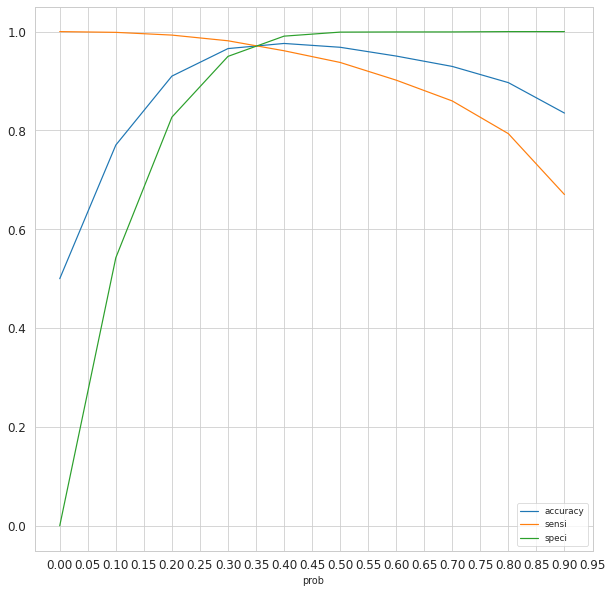

In [247]:
# plot to find out the right threshold
sns.set_style("whitegrid") 
sns.set_context("paper") 
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'], figsize=(10,10))
# plot x axis limits
plt.xticks(np.arange(0, 1, step=0.05), size = 12, )
plt.yticks(size = 12)
plt.show()

In [248]:
# Let's choose 0.35 as cut-off
# Creating new column 'final_predicted' with 1 if predicted_prob > 0.35 else 0
y_train_pred_final['final_predicted'] = y_train_pred_final.predicted_prob.map( lambda x: 1 if x > 0.35 else 0)
y_train_pred_final.head()

,original_sentiments,predicted_prob,ID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.981501,0,1,1,1,1,1,1,1,1,1,1,1
1,1,0.996772,1,1,1,1,1,1,1,1,1,1,1,1
2,1,0.981962,2,1,1,1,1,1,1,1,1,1,1,1
3,1,0.998047,3,1,1,1,1,1,1,1,1,1,1,1
4,0,0.201527,4,1,1,1,0,0,0,0,0,0,0,0


In [249]:
confusion_m = confusion_matrix(y_train_pred_final.original_sentiments, y_train_pred_final.final_predicted)
confusion_m

array([[15604,   293],
       [  438, 15459]])

In [252]:
TP = confusion_m[1, 1] # true positive 
TN = confusion_m[0, 0] # true negatives
FP = confusion_m[0, 1] # false positives
FN = confusion_m[1, 0] # false negatives

sensitivity_m = round((TP / float(TP+FN)), 4)
specificity_m = round((TN / float(TN+FP)), 4)
precision_m = round((TP / float(TP+FP)), 4)

print('Precision:\t\t', precision_m)
print('Sensitivity/Recall:\t', sensitivity_m)
print('Specificity:\t\t', specificity_m)

Precision:		 0.9814
Sensitivity/Recall:	 0.9724
Specificity:		 0.9816


In [253]:
test_pred_prob=final_model.predict_proba(X_test)[:,1]
y_test_pred_final = pd.DataFrame({'original_sentiments':y_test, 'predicted_prob':test_pred_prob})
y_test_pred_final.head()

,original_sentiments,predicted_prob
18801,0,0.909173
11267,1,0.999026
3527,1,0.972238
26107,1,0.995897
6023,1,0.946325


In [254]:
# cut-off is 0.35
y_test_pred_final['final_predicted'] = y_test_pred_final.predicted_prob.map(lambda x: 1 if x > 0.35 else 0)
y_test_pred_final.head()

,original_sentiments,predicted_prob,final_predicted
18801,0,0.909173,1
11267,1,0.999026,1
3527,1,0.972238,1
26107,1,0.995897,1
6023,1,0.946325,1


In [255]:
confusion_t = confusion_matrix(y_test_pred_final.original_sentiments, y_test_pred_final.final_predicted )
confusion_t

array([[ 389,  433],
       [ 301, 6525]])

In [256]:
TP = confusion_t[1, 1] # true positive 
TN = confusion_t[0, 0] # true negatives
FP = confusion_t[0, 1] # false positives
FN = confusion_t[1, 0] # false negatives

sensitivity_t = round((TP / float(TP+FN)), 4)
specificity_t = round((TN / float(TN+FP)), 4)
precision_t = round((TP / float(TP+FP)), 4)

print('Precision:\t\t', precision_t)
print('Sensitivity/Recall:\t', sensitivity_t)
print('Specificity:\t\t', specificity_t)

Precision:		 0.9378
Sensitivity/Recall:	 0.9559
Specificity:		 0.4732


In [260]:
pred_t = final_model.predict_proba(X_test)[:,1]
auc_score_t = roc_auc_score(y_test, pred_t)

print("ROC-AUC Score:\t\t", auc_score_t)

ROC-AUC Score:		 0.8854797350619465


## Recommendation Systems:

In [251]:
from sklearn.metrics.pairwise import pairwise_distances

In [131]:
# Make sure there are no duplicate reviews of same product by same user, which we have already cleaned up before our sentiment model building
prdf[prdf.duplicated(['user_name','product_name'], keep=False)].head(10)

,product_id,categories,purchased,recommended,rating,review_original,review_title,user_name,user_sentiment,product_name,year,review_merged,promotional,review_processed,sentiment


In [132]:
print('Unique values of Product ID', len(prdf.product_id.unique()))
print('Unique values of Product name', len(prdf.product_name.unique()))

Unique values of Product ID 204
Unique values of Product name 204


In [133]:
prdf_reco = prdf[['product_name', 'user_name', 'rating']]

In [134]:
prdf_reco = prdf_reco.groupby(by = ['product_name','user_name']).mean()
prdf_reco.reset_index(inplace = True)

In [135]:
# Split into test and train
df_train, df_test = train_test_split(prdf_reco, test_size = 0.25, random_state=42)

In [136]:
# Dummy Train and Dummy Test
dummy_train = df_train.copy()

In [137]:
# Since we dont want to recommend same product that user has rated already, we can ignore them
dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x >= 0 else 1) 

In [138]:
dummy_train.sample(5)

,product_name,user_name,rating
2985,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",martinator,0
23437,Warner Home Video Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,jres,0
1385,AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner,jodi1164,0
20942,Walt Disney Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),diver13,0
6061,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,cuttlefish,0


In [139]:
# pivoting the dummy train 
dummy_train = dummy_train.pivot_table(index ='user_name', columns ='product_name', values ='rating').fillna(1)
dummy_train.head()

product_name,Alex Cross (dvdvideo),0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,120 2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,120 Post Bound Jumbo Album - Burgundy (11x14),"1200 Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish",20th Century Fox There's Something About Mary (dvd),"AUSTRALIAN GOLD PRODUCTS LTD. Australian Gold Exotic Blend Lotion, SPF 4",AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner,American Coffee Partnership Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,American Pop Corn Co. Jolly Time Select Premium Yellow Pop Corn,Annie's Homegrown Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Annies Homegrown Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Arc Abrasives Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery Dennison Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,BNRG Power Crunch Protein Energy Bar Peanut Butter Creme Original,"Beautyge Brands USA, Inc. Creme Of Nature Intensive Conditioning Treatment, 32",Boraam - DROPSHIP Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Broken Bow Jason Aldean - They Don't Know,Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","CREATIVE CONVERTING Candy Pink Plastic Cups, 20 pk","Cadbury Schweppes Americas Beverages RC Cola, 12oz",Calvin Klein Secret Obsession Eau De Parfum,Capitol Various - Red Hot Blue:Tribute To Cole Porter (cd),"Caress Moisturizing Body Bar Natural Silk, 4.75oz",CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheatham Chemical Co. Africa's Best No-Lye Dual Conditioning Relaxer System Super,Chooka Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Citrus Magic Instant Spot & Stain Remover,Clear Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare Skin Care Cococare 100% Natural Castor Oil,Columbia The Script - No Sound Without Silence (cd),"Combe Incorporated Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty brands Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,DISNEY/BUENA VISTA HOME VIDEO Doc Mcstuffins: Friendship Is The Best Medicine,Delta Delta Single Handle Shower Faucet,Discovery Foods Tai Pei Sweet & Sour Chicken,Disney/Pixar Cars Toon: Mater's Tall Tales,"Dr Pepper/Seven Up, Inc Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans","Dr Pepper/Seven Up, Inc Hawaiian Punch Berry Limeade Blast Juice",E&E Co. Ltd Kendall Comforter And Sheet Set (twin) Aqua - 7pc,"Eagle Family Foods, Inc. Eagle Fat Free Sweetened Condensed Milk","Energizer Personal Care Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium","Era liquid detergent 2x Ultra Era with Oxi Booster, 50fl oz","Esselte Corporation Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",FLEMING & CO Ambi Complexion Cleansing Bar,Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Fiskars Brands Inc Fiskars174 Classic Stick Rotary Cutter (45 Mm),Frito-Lay Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Frito-Lay Chester's Cheese Flavored Puffcorn Snacks,Frito-Lay Tostitos Simply Blue Corn Tortilla Chips,"GENERAL MILLS SALES, INC. Bisquick Original Pancake And Baking Mix - 40oz","GENERAL MILLS SALES, INC. Chex Muddy Buddies Brownie Supreme Snack Mix","GENERAL MILLS SALES, INC. Progresso Light Vegetable & Noodle Soup","GHP Group, Inc. Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Mediu

In [140]:
# Create user-product matrix:
df_pivot = df_train.pivot_table(index ='user_name', columns ='product_name', values ='rating').fillna(0)

In [141]:
df_pivot.shape

(17588, 192)

In [142]:
df_pivot.head()

product_name,Alex Cross (dvdvideo),0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,120 2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,120 Post Bound Jumbo Album - Burgundy (11x14),"1200 Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish",20th Century Fox There's Something About Mary (dvd),"AUSTRALIAN GOLD PRODUCTS LTD. Australian Gold Exotic Blend Lotion, SPF 4",AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner,American Coffee Partnership Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,American Pop Corn Co. Jolly Time Select Premium Yellow Pop Corn,Annie's Homegrown Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Annies Homegrown Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Arc Abrasives Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery Dennison Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,BNRG Power Crunch Protein Energy Bar Peanut Butter Creme Original,"Beautyge Brands USA, Inc. Creme Of Nature Intensive Conditioning Treatment, 32",Boraam - DROPSHIP Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Broken Bow Jason Aldean - They Don't Know,Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","CREATIVE CONVERTING Candy Pink Plastic Cups, 20 pk","Cadbury Schweppes Americas Beverages RC Cola, 12oz",Calvin Klein Secret Obsession Eau De Parfum,Capitol Various - Red Hot Blue:Tribute To Cole Porter (cd),"Caress Moisturizing Body Bar Natural Silk, 4.75oz",CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheatham Chemical Co. Africa's Best No-Lye Dual Conditioning Relaxer System Super,Chooka Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Citrus Magic Instant Spot & Stain Remover,Clear Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare Skin Care Cococare 100% Natural Castor Oil,Columbia The Script - No Sound Without Silence (cd),"Combe Incorporated Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty brands Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,DISNEY/BUENA VISTA HOME VIDEO Doc Mcstuffins: Friendship Is The Best Medicine,Delta Delta Single Handle Shower Faucet,Discovery Foods Tai Pei Sweet & Sour Chicken,Disney/Pixar Cars Toon: Mater's Tall Tales,"Dr Pepper/Seven Up, Inc Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans","Dr Pepper/Seven Up, Inc Hawaiian Punch Berry Limeade Blast Juice",E&E Co. Ltd Kendall Comforter And Sheet Set (twin) Aqua - 7pc,"Eagle Family Foods, Inc. Eagle Fat Free Sweetened Condensed Milk","Energizer Personal Care Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium","Era liquid detergent 2x Ultra Era with Oxi Booster, 50fl oz","Esselte Corporation Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",FLEMING & CO Ambi Complexion Cleansing Bar,Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Fiskars Brands Inc Fiskars174 Classic Stick Rotary Cutter (45 Mm),Frito-Lay Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Frito-Lay Chester's Cheese Flavored Puffcorn Snacks,Frito-Lay Tostitos Simply Blue Corn Tortilla Chips,"GENERAL MILLS SALES, INC. Bisquick Original Pancake And Baking Mix - 40oz","GENERAL MILLS SALES, INC. Chex Muddy Buddies Brownie Supreme Snack Mix","GENERAL MILLS SALES, INC. Progresso Light Vegetable & Noodle Soup","GHP Group, Inc. Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Mediu

In [143]:
df_pivot.index.nunique()

17588

### User Based Recommendation System:

In [144]:
# User Similarity Matrix:
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.        0.        0.        ... 0.        0.        0.       ]
 [0.        1.        0.        ... 0.        0.        0.9486833]
 [0.        0.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        1.        0.       ]
 [0.        0.        0.        ... 1.        1.        0.       ]
 [0.        0.9486833 0.        ... 0.        0.        1.       ]]


In [145]:
user_correlation.shape

(17588, 17588)

In [146]:
df_pivot = df_train.pivot(
    index='user_name',
    columns='product_name',
    values='rating'
)

In [147]:
df_pivot.head()

product_name,Alex Cross (dvdvideo),0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,120 2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,120 Post Bound Jumbo Album - Burgundy (11x14),"1200 Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish",20th Century Fox There's Something About Mary (dvd),"AUSTRALIAN GOLD PRODUCTS LTD. Australian Gold Exotic Blend Lotion, SPF 4",AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner,American Coffee Partnership Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,American Pop Corn Co. Jolly Time Select Premium Yellow Pop Corn,Annie's Homegrown Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Annies Homegrown Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Arc Abrasives Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery Dennison Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,BNRG Power Crunch Protein Energy Bar Peanut Butter Creme Original,"Beautyge Brands USA, Inc. Creme Of Nature Intensive Conditioning Treatment, 32",Boraam - DROPSHIP Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Broken Bow Jason Aldean - They Don't Know,Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","CREATIVE CONVERTING Candy Pink Plastic Cups, 20 pk","Cadbury Schweppes Americas Beverages RC Cola, 12oz",Calvin Klein Secret Obsession Eau De Parfum,Capitol Various - Red Hot Blue:Tribute To Cole Porter (cd),"Caress Moisturizing Body Bar Natural Silk, 4.75oz",CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheatham Chemical Co. Africa's Best No-Lye Dual Conditioning Relaxer System Super,Chooka Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Citrus Magic Instant Spot & Stain Remover,Clear Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare Skin Care Cococare 100% Natural Castor Oil,Columbia The Script - No Sound Without Silence (cd),"Combe Incorporated Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty brands Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,DISNEY/BUENA VISTA HOME VIDEO Doc Mcstuffins: Friendship Is The Best Medicine,Delta Delta Single Handle Shower Faucet,Discovery Foods Tai Pei Sweet & Sour Chicken,Disney/Pixar Cars Toon: Mater's Tall Tales,"Dr Pepper/Seven Up, Inc Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans","Dr Pepper/Seven Up, Inc Hawaiian Punch Berry Limeade Blast Juice",E&E Co. Ltd Kendall Comforter And Sheet Set (twin) Aqua - 7pc,"Eagle Family Foods, Inc. Eagle Fat Free Sweetened Condensed Milk","Energizer Personal Care Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium","Era liquid detergent 2x Ultra Era with Oxi Booster, 50fl oz","Esselte Corporation Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",FLEMING & CO Ambi Complexion Cleansing Bar,Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Fiskars Brands Inc Fiskars174 Classic Stick Rotary Cutter (45 Mm),Frito-Lay Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Frito-Lay Chester's Cheese Flavored Puffcorn Snacks,Frito-Lay Tostitos Simply Blue Corn Tortilla Chips,"GENERAL MILLS SALES, INC. Bisquick Original Pancake And Baking Mix - 40oz","GENERAL MILLS SALES, INC. Chex Muddy Buddies Brownie Supreme Snack Mix","GENERAL MILLS SALES, INC. Progresso Light Vegetable & Noodle Soup","GHP Group, Inc. Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Mediu

In [148]:
# Normalizing ratings
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T - mean).T

In [149]:
df_subtracted.head()

product_name,Alex Cross (dvdvideo),0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,120 2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,120 Post Bound Jumbo Album - Burgundy (11x14),"1200 Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish",20th Century Fox There's Something About Mary (dvd),"AUSTRALIAN GOLD PRODUCTS LTD. Australian Gold Exotic Blend Lotion, SPF 4",AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner,American Coffee Partnership Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,American Pop Corn Co. Jolly Time Select Premium Yellow Pop Corn,Annie's Homegrown Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Annies Homegrown Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Arc Abrasives Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery Dennison Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,BNRG Power Crunch Protein Energy Bar Peanut Butter Creme Original,"Beautyge Brands USA, Inc. Creme Of Nature Intensive Conditioning Treatment, 32",Boraam - DROPSHIP Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Broken Bow Jason Aldean - They Don't Know,Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","CREATIVE CONVERTING Candy Pink Plastic Cups, 20 pk","Cadbury Schweppes Americas Beverages RC Cola, 12oz",Calvin Klein Secret Obsession Eau De Parfum,Capitol Various - Red Hot Blue:Tribute To Cole Porter (cd),"Caress Moisturizing Body Bar Natural Silk, 4.75oz",CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheatham Chemical Co. Africa's Best No-Lye Dual Conditioning Relaxer System Super,Chooka Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Citrus Magic Instant Spot & Stain Remover,Clear Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare Skin Care Cococare 100% Natural Castor Oil,Columbia The Script - No Sound Without Silence (cd),"Combe Incorporated Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty brands Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,DISNEY/BUENA VISTA HOME VIDEO Doc Mcstuffins: Friendship Is The Best Medicine,Delta Delta Single Handle Shower Faucet,Discovery Foods Tai Pei Sweet & Sour Chicken,Disney/Pixar Cars Toon: Mater's Tall Tales,"Dr Pepper/Seven Up, Inc Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans","Dr Pepper/Seven Up, Inc Hawaiian Punch Berry Limeade Blast Juice",E&E Co. Ltd Kendall Comforter And Sheet Set (twin) Aqua - 7pc,"Eagle Family Foods, Inc. Eagle Fat Free Sweetened Condensed Milk","Energizer Personal Care Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium","Era liquid detergent 2x Ultra Era with Oxi Booster, 50fl oz","Esselte Corporation Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",FLEMING & CO Ambi Complexion Cleansing Bar,Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Fiskars Brands Inc Fiskars174 Classic Stick Rotary Cutter (45 Mm),Frito-Lay Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Frito-Lay Chester's Cheese Flavored Puffcorn Snacks,Frito-Lay Tostitos Simply Blue Corn Tortilla Chips,"GENERAL MILLS SALES, INC. Bisquick Original Pancake And Baking Mix - 40oz","GENERAL MILLS SALES, INC. Chex Muddy Buddies Brownie Supreme Snack Mix","GENERAL MILLS SALES, INC. Progresso Light Vegetable & Noodle Soup","GHP Group, Inc. Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Mediu

In [150]:
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [151]:
user_correlation.shape

(17588, 17588)

In [152]:
# Ignore users with negative correlation
user_correlation[user_correlation < 0] = 0

In [153]:
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [154]:
# Rating predicted by the user is the weighted sum of correlation with the product rating using Dot-Product
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_final_rating = np.multiply(user_predicted_ratings, dummy_train)

In [155]:
user_predicted_ratings.shape

(17588, 192)

In [156]:
user_final_rating.head()

product_name,Alex Cross (dvdvideo),0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,120 2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,120 Post Bound Jumbo Album - Burgundy (11x14),"1200 Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish",20th Century Fox There's Something About Mary (dvd),"AUSTRALIAN GOLD PRODUCTS LTD. Australian Gold Exotic Blend Lotion, SPF 4",AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner,American Coffee Partnership Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,American Pop Corn Co. Jolly Time Select Premium Yellow Pop Corn,Annie's Homegrown Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Annies Homegrown Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Arc Abrasives Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery Dennison Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,BNRG Power Crunch Protein Energy Bar Peanut Butter Creme Original,"Beautyge Brands USA, Inc. Creme Of Nature Intensive Conditioning Treatment, 32",Boraam - DROPSHIP Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Broken Bow Jason Aldean - They Don't Know,Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","CREATIVE CONVERTING Candy Pink Plastic Cups, 20 pk","Cadbury Schweppes Americas Beverages RC Cola, 12oz",Calvin Klein Secret Obsession Eau De Parfum,Capitol Various - Red Hot Blue:Tribute To Cole Porter (cd),"Caress Moisturizing Body Bar Natural Silk, 4.75oz",CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheatham Chemical Co. Africa's Best No-Lye Dual Conditioning Relaxer System Super,Chooka Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Citrus Magic Instant Spot & Stain Remover,Clear Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare Skin Care Cococare 100% Natural Castor Oil,Columbia The Script - No Sound Without Silence (cd),"Combe Incorporated Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty brands Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,DISNEY/BUENA VISTA HOME VIDEO Doc Mcstuffins: Friendship Is The Best Medicine,Delta Delta Single Handle Shower Faucet,Discovery Foods Tai Pei Sweet & Sour Chicken,Disney/Pixar Cars Toon: Mater's Tall Tales,"Dr Pepper/Seven Up, Inc Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans","Dr Pepper/Seven Up, Inc Hawaiian Punch Berry Limeade Blast Juice",E&E Co. Ltd Kendall Comforter And Sheet Set (twin) Aqua - 7pc,"Eagle Family Foods, Inc. Eagle Fat Free Sweetened Condensed Milk","Energizer Personal Care Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium","Era liquid detergent 2x Ultra Era with Oxi Booster, 50fl oz","Esselte Corporation Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",FLEMING & CO Ambi Complexion Cleansing Bar,Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Fiskars Brands Inc Fiskars174 Classic Stick Rotary Cutter (45 Mm),Frito-Lay Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Frito-Lay Chester's Cheese Flavored Puffcorn Snacks,Frito-Lay Tostitos Simply Blue Corn Tortilla Chips,"GENERAL MILLS SALES, INC. Bisquick Original Pancake And Baking Mix - 40oz","GENERAL MILLS SALES, INC. Chex Muddy Buddies Brownie Supreme Snack Mix","GENERAL MILLS SALES, INC. Progresso Light Vegetable & Noodle Soup","GHP Group, Inc. Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Mediu

In [157]:
top5_recommendations = pd.DataFrame(user_final_rating.loc['samantha'].sort_values(ascending=False)[0:5])
top5_recommendations

,samantha
product_name,
Warner Home Video Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,20.586553
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,7.404099
Broken Bow Jason Aldean - They Don't Know,5.735459
Tostitos Bite Size Tortilla Chips,5.324715
Walt Disney Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),4.797471


### Evaluate the User-Based Recommendation System:

In [158]:
common_users = df_test[df_test.user_name.isin(df_train.user_name)]
common_users.shape

(826, 3)

In [159]:
common_users.head()

,product_name,user_name,rating
8304,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,lakelovin,5
2874,BNRG Power Crunch Protein Energy Bar Peanut Butter Creme Original,debbie,5
1103,AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner,elizaraeb,5
7747,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,juliet,5
6871,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,greyson428,4


In [160]:
common_user_based_matrix = common_users.pivot_table(index='user_name', columns='product_name', values='rating')
common_user_based_matrix.shape

(726, 80)

In [161]:
common_user_based_matrix.head()

product_name,Alex Cross (dvdvideo),120 Post Bound Jumbo Album - Burgundy (11x14),20th Century Fox There's Something About Mary (dvd),"AUSTRALIAN GOLD PRODUCTS LTD. Australian Gold Exotic Blend Lotion, SPF 4",AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner,"Avery Dennison Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",BNRG Power Crunch Protein Energy Bar Peanut Butter Creme Original,"Beautyge Brands USA, Inc. Creme Of Nature Intensive Conditioning Treatment, 32",Boraam - DROPSHIP Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Broken Bow Jason Aldean - They Don't Know,Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Caress Moisturizing Body Bar Natural Silk, 4.75oz",Clear Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Combe Incorporated Just For Men Touch Of Gray Gray Hair Treatment, Black T-55","Coty brands Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,Discovery Foods Tai Pei Sweet & Sour Chicken,Disney/Pixar Cars Toon: Mater's Tall Tales,"Dr Pepper/Seven Up, Inc Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans","Dr Pepper/Seven Up, Inc Hawaiian Punch Berry Limeade Blast Juice","Eagle Family Foods, Inc. Eagle Fat Free Sweetened Condensed Milk","Energizer Personal Care Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium","Esselte Corporation Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",FLEMING & CO Ambi Complexion Cleansing Bar,Frito-Lay Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Frito-Lay Chester's Cheese Flavored Puffcorn Snacks,Frito-Lay Tostitos Simply Blue Corn Tortilla Chips,"GENERAL MILLS SALES, INC. Bisquick Original Pancake And Baking Mix - 40oz","General Mills Sales, Inc. Progresso Traditional Chicken Tuscany Soup","Generic Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz","Hormel Chili, No Beans",Hormel Foods Corporation Spam Single Classic,Jarden Home Environment Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,K-Y Love Sensuality Pleasure Gel,Kellogg Sales Co Chips Deluxe Soft 'n Chewy Cookies,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,"L'oreal Paris Colour Caresse Wet Shine Stain, Pink Resistance",Lions Gate Equals (blu-Ray),Lions Gate Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),Little Bedding Little Bedding By Nojo Jungle Dreams 2 Pack Sheet Set,Mrs. Meyers Mrs. Meyer's Lemon Verbena Surface Scrub,Nabisco Biscuit Company Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,"Naterra International Tree Hut Shea Body Butters, Coconut Lime, 7 oz","Newman's Own, Inc. Newman's Own Balsamic Vinaigrette, 16.0oz",Nexxus Beauty Products Nexxus Exxtra Gel Style Creation Sculptor,Orajel Maximum Strength Toothache Pain Relief Liquid,P&G Olay Regenerist Deep Hydration Regenerating Cream,"P&G Vicks Vaporub, Regular, 3.53oz",Pantene Pro-V Hair Care Pantene Pro-V Expert Collection Age Defy Conditioner,Parts Meguiar's Deep Crystal Car Wash 64-Oz.,Procter & Gamble Company Head & Shoulders Classic Clean Conditioner,Reckitt Benckiser D-Con Mice Bait Station - 3ct,"Reckitt Benckiser Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count","Reckitt Benckiser Lysol Concentrate Deodorizing Cleaner, Original Scent",Red (special Edition) (dvdvideo),"SMEAD MANUFACTURING CO. Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",SONY CORP The Resident Evil Collection 5 Discs (blu-Ray),Solo Solo Foods Poppy Seed Cake and Pastry Filling,Stacy's Simply Naked Bagel Chips,TIME WARNER Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Tostitos Bite Size Tortilla Chips,Tresemme Kertatin Smooth Infusing Conditioning,Twentieth Century Fox Mike Dave Need Wedding Dates (dvd + Di

In [162]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.shape

(17588, 17588)

In [163]:
user_correlation_df.head()

Output hidden; open in https://colab.research.google.com to view.

In [164]:
df_subtracted.shape

(17588, 192)

In [165]:
user_correlation_df['user_name'] = df_subtracted.index
user_correlation_df.set_index('user_name', inplace=True)
user_correlation_df.shape

(17588, 17588)

In [166]:
user_correlation_df.head()

Output hidden; open in https://colab.research.google.com to view.

In [167]:
common_users.head()

,product_name,user_name,rating
8304,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,lakelovin,5
2874,BNRG Power Crunch Protein Energy Bar Peanut Butter Creme Original,debbie,5
1103,AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner,elizaraeb,5
7747,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,juliet,5
6871,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,greyson428,4


In [168]:
list_name = common_users.user_name.tolist()
user_correlation_df.columns = df_subtracted.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

user_correlation_df.shape

(17588, 17588)

In [169]:
user_correlation_df_1.shape

(726, 17588)

In [170]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [171]:
user_correlation_df_3 = user_correlation_df_2.T
user_correlation_df_3.shape

(726, 726)

In [172]:
user_correlation_df_3.head()

,123charlie,1witch,aaron,abby,adam,adriana,aimee,ajeff,aktcharlotte,alex,alexis,alice,allie,ally,amanda,amanda13,amandarose,amber,amlyke,ammcam,ammi,amor,amy1,amyw333,anatnas4,andie,andrea,andy,ang32,angc,angel,angie,anne,anon,april,arob,artteacher,as123,ashley,awesome,ayterrazas,azchick,balvarado1970,banana,bananakitty,barb,barb24,bas56,bbbb,bean,becca,becky,becky39,beebee,belle,berly,bernie,beth,beth46,betty,bg13,bigb,bigd,bigdaddy,bigdog,blt66,blue,bobbi,bobo,bonbon,bongojack,boobie1973,booboo,boomer,brad,brandi1982,bren,brenda,brian,bubba,bubblegum197035,bucket,bullhorn,bzmama,calicutie,cally,cami,carol,caroline,casey,casper87,cassie,castle,cathy,cber,cecy89,champ,charles,charlie,chas,chels,chief,chocolate,chraaaa,chris,chrissy,christa,christina,cindy1834,cjhays,cjsmom,clanoux,clean freak,cleaner4,clnhse,cloroxfan12,cmerck2006,cmorgan,cnagirl69,connie36,cookie0258,coribecca,coronadad,cougar,couponcara,court,cowboy,crazylady5911,cricket,criggs,crystal,cubby,daddypanda00,dadof2b1g,dahrcy,dale,dandan,daner,dani,danielle,danman,danny,darlene,dave,dawn59,debbie,debby13,debd,deda,dee0581,dee2,del737,delias00,denise,denise22,desi03,detets,dhm66,diana,diane,dianne,difain,dino,disappointed,disappointed customer,diver13,dmobley,doglover,dolly,doloresnyc,donna,donnamax,donny304,doris60,doug,drabo,dragonfly,drak,dre4,drea,drew,ducklove,dunerunner007,eclausen91,eddie888,edgar,ejaky,eliza,elizaraeb,ellen59,elway82,emerald,emily,emmylou,eric,erica958,erin,ermak23,evecoup,faceman69,faithful,fallenangel2636,fffunnylady33,flower,floyd,fluffy,foreather,frank,frankie,franny,gabi,gaby,gatorbobert,gemma1959,george,george08,giggles,gigi,gina,ginger,girlie,gma22,gonzo,goofy4prez,gram,grandma,grandpa,greggery,greyson428,gtech,gtguru497,guznnar,handbelllady,hannah,happy,hazel,hdriller,heather4,heli,hfred23,hillary29,holld,hoolahgirl,hr32,hrd0426,hutch69,ickysurfacecleaner,iluvbbtechstuff,indy,infamous,islandgirl671,itsme,jab522,jack,jack12720,jackie,jake,james,jamie82,jamo,janice,jasmine,jason,jayjay,jayme,jbroz23,jclark481,jcole,jdawg,jeall,jean,jeanne,jeff,jen,jeng,jenn,jenna4,jennaleigh,jenni,jennie,jennifer,jennnnnnnnn,jenny,jenny28,jenstitch940,jerbear,jeremy223,jerri,jess,jess17,jesse,jessica,jessica26,jessie,jessie26,jilly,jimbo,jimmy,jimvil,jj1124,jlamom,jlm75,jlowrance,jls1149,jlynn,jo1130anna,joanne,joanngr22,jody,joel,joem,joey,john,johnny,jojo,jonathan,josh,joshua,jssmith,judith,judy,juice,jujubee,jules,julia,julie,juliet,junior,justin,jygibri,kara,karen,karen1,karenjd,kat410,katdean,kate,kathie,kathryn,kathy,kathyb,katieaz,katygirl79,kaye,kaye52,kdearman,keebler,keith,kell,kells,kelly,kellyk,kenny,kimmi,king,kishakat00,kk1109,klh2167,klind,kong,kornick,kp41,kris,kris006,kristine,kurt,lacey214,lady,ladybugpam,ladyhaha,ladyslverfyr,lakelovin,lala,lance,larry,lashopper,laura,laura30,lb17,lbarnett,lcc3,le30,lean,leighd,lety,lfitzpat,lggarrett2,lily,linda,lindalou,lindsay,lindsey25,linny,lisa,lisa84,lisag537,lisagirl,liss77,lissa73,lissab,liz124,lmg1135,lolo1980,lorandal,loretta11111,lori,loris,lorlor21,loulou,lringhol,lsbair,luisa,lulu,lulu50,lupi2010,lynnl,m52003,macdaddy,mack,macoup,madalina,maekare,maggie,mama,mama2,mamabear,mamad,mamwaa,mandylou,mandyw21499,manny,marcus,mari58,maria101,marinewife,mario,mark,marry,marsha,marshy72,mary,mary14,maryb,matt,maverick,maximus,maya,mcdon22,mecawecakte,megs,meme,meme13,memyself2,mia214jia,michael,michelle,michelle098,michelle15,mickey,mike,mikel,mikey,milo,mimi,mindy,minnie,missaye1231,missy,missy716,mizliz83,mokan,mom03,mom23,momma,momof2,momof3,momof3boys,momof4,momofboys3,momonhand,mongo,moni,moocow,morehumanthanhuman,morgan,motherlovin,mouse,moviefan,moviejunkie,movielover,movieperson825,mrobins,msd11,msdaisy,mudcat75979,mugs,music,mustang,myra,myreview,nan71,nana,nanabanana,nance,nancy,nanna,nar1404,natalie4717,nativechicka,nellie,nelz214,nessa,neto,newmom10,next1973,nguyet11,nicole,nikki,nikki89,nina,noname,norbey,ojoe61,onthego,oscar,packersmumm,paige,pammy,panda,patti,patty,pattycake,pau

In [173]:
user_correlation_df_3[user_correlation_df_3 < 0] = 0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [174]:
common_user_predicted_ratings.shape

(726, 80)

In [175]:
common_users.shape

(826, 3)

In [176]:
dummy_test = common_users.copy()
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x >= 1 else 0)
dummy_test = dummy_test.pivot_table(index='user_name', columns='product_name', values='rating').fillna(0)

dummy_test.shape

(726, 80)

In [177]:
common_user_based_matrix.head()

product_name,Alex Cross (dvdvideo),120 Post Bound Jumbo Album - Burgundy (11x14),20th Century Fox There's Something About Mary (dvd),"AUSTRALIAN GOLD PRODUCTS LTD. Australian Gold Exotic Blend Lotion, SPF 4",AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner,"Avery Dennison Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",BNRG Power Crunch Protein Energy Bar Peanut Butter Creme Original,"Beautyge Brands USA, Inc. Creme Of Nature Intensive Conditioning Treatment, 32",Boraam - DROPSHIP Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Broken Bow Jason Aldean - They Don't Know,Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Caress Moisturizing Body Bar Natural Silk, 4.75oz",Clear Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Combe Incorporated Just For Men Touch Of Gray Gray Hair Treatment, Black T-55","Coty brands Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,Discovery Foods Tai Pei Sweet & Sour Chicken,Disney/Pixar Cars Toon: Mater's Tall Tales,"Dr Pepper/Seven Up, Inc Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans","Dr Pepper/Seven Up, Inc Hawaiian Punch Berry Limeade Blast Juice","Eagle Family Foods, Inc. Eagle Fat Free Sweetened Condensed Milk","Energizer Personal Care Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium","Esselte Corporation Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",FLEMING & CO Ambi Complexion Cleansing Bar,Frito-Lay Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Frito-Lay Chester's Cheese Flavored Puffcorn Snacks,Frito-Lay Tostitos Simply Blue Corn Tortilla Chips,"GENERAL MILLS SALES, INC. Bisquick Original Pancake And Baking Mix - 40oz","General Mills Sales, Inc. Progresso Traditional Chicken Tuscany Soup","Generic Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz","Hormel Chili, No Beans",Hormel Foods Corporation Spam Single Classic,Jarden Home Environment Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,K-Y Love Sensuality Pleasure Gel,Kellogg Sales Co Chips Deluxe Soft 'n Chewy Cookies,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,"L'oreal Paris Colour Caresse Wet Shine Stain, Pink Resistance",Lions Gate Equals (blu-Ray),Lions Gate Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),Little Bedding Little Bedding By Nojo Jungle Dreams 2 Pack Sheet Set,Mrs. Meyers Mrs. Meyer's Lemon Verbena Surface Scrub,Nabisco Biscuit Company Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,"Naterra International Tree Hut Shea Body Butters, Coconut Lime, 7 oz","Newman's Own, Inc. Newman's Own Balsamic Vinaigrette, 16.0oz",Nexxus Beauty Products Nexxus Exxtra Gel Style Creation Sculptor,Orajel Maximum Strength Toothache Pain Relief Liquid,P&G Olay Regenerist Deep Hydration Regenerating Cream,"P&G Vicks Vaporub, Regular, 3.53oz",Pantene Pro-V Hair Care Pantene Pro-V Expert Collection Age Defy Conditioner,Parts Meguiar's Deep Crystal Car Wash 64-Oz.,Procter & Gamble Company Head & Shoulders Classic Clean Conditioner,Reckitt Benckiser D-Con Mice Bait Station - 3ct,"Reckitt Benckiser Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count","Reckitt Benckiser Lysol Concentrate Deodorizing Cleaner, Original Scent",Red (special Edition) (dvdvideo),"SMEAD MANUFACTURING CO. Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",SONY CORP The Resident Evil Collection 5 Discs (blu-Ray),Solo Solo Foods Poppy Seed Cake and Pastry Filling,Stacy's Simply Naked Bagel Chips,TIME WARNER Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Tostitos Bite Size Tortilla Chips,Tresemme Kertatin Smooth Infusing Conditioning,Twentieth Century Fox Mike Dave Need Wedding Dates (dvd + Di

In [178]:
dummy_test.head()

product_name,Alex Cross (dvdvideo),120 Post Bound Jumbo Album - Burgundy (11x14),20th Century Fox There's Something About Mary (dvd),"AUSTRALIAN GOLD PRODUCTS LTD. Australian Gold Exotic Blend Lotion, SPF 4",AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner,"Avery Dennison Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",BNRG Power Crunch Protein Energy Bar Peanut Butter Creme Original,"Beautyge Brands USA, Inc. Creme Of Nature Intensive Conditioning Treatment, 32",Boraam - DROPSHIP Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Broken Bow Jason Aldean - They Don't Know,Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Caress Moisturizing Body Bar Natural Silk, 4.75oz",Clear Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Combe Incorporated Just For Men Touch Of Gray Gray Hair Treatment, Black T-55","Coty brands Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,Discovery Foods Tai Pei Sweet & Sour Chicken,Disney/Pixar Cars Toon: Mater's Tall Tales,"Dr Pepper/Seven Up, Inc Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans","Dr Pepper/Seven Up, Inc Hawaiian Punch Berry Limeade Blast Juice","Eagle Family Foods, Inc. Eagle Fat Free Sweetened Condensed Milk","Energizer Personal Care Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium","Esselte Corporation Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",FLEMING & CO Ambi Complexion Cleansing Bar,Frito-Lay Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Frito-Lay Chester's Cheese Flavored Puffcorn Snacks,Frito-Lay Tostitos Simply Blue Corn Tortilla Chips,"GENERAL MILLS SALES, INC. Bisquick Original Pancake And Baking Mix - 40oz","General Mills Sales, Inc. Progresso Traditional Chicken Tuscany Soup","Generic Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz","Hormel Chili, No Beans",Hormel Foods Corporation Spam Single Classic,Jarden Home Environment Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,K-Y Love Sensuality Pleasure Gel,Kellogg Sales Co Chips Deluxe Soft 'n Chewy Cookies,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,"L'oreal Paris Colour Caresse Wet Shine Stain, Pink Resistance",Lions Gate Equals (blu-Ray),Lions Gate Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),Little Bedding Little Bedding By Nojo Jungle Dreams 2 Pack Sheet Set,Mrs. Meyers Mrs. Meyer's Lemon Verbena Surface Scrub,Nabisco Biscuit Company Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,"Naterra International Tree Hut Shea Body Butters, Coconut Lime, 7 oz","Newman's Own, Inc. Newman's Own Balsamic Vinaigrette, 16.0oz",Nexxus Beauty Products Nexxus Exxtra Gel Style Creation Sculptor,Orajel Maximum Strength Toothache Pain Relief Liquid,P&G Olay Regenerist Deep Hydration Regenerating Cream,"P&G Vicks Vaporub, Regular, 3.53oz",Pantene Pro-V Hair Care Pantene Pro-V Expert Collection Age Defy Conditioner,Parts Meguiar's Deep Crystal Car Wash 64-Oz.,Procter & Gamble Company Head & Shoulders Classic Clean Conditioner,Reckitt Benckiser D-Con Mice Bait Station - 3ct,"Reckitt Benckiser Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count","Reckitt Benckiser Lysol Concentrate Deodorizing Cleaner, Original Scent",Red (special Edition) (dvdvideo),"SMEAD MANUFACTURING CO. Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",SONY CORP The Resident Evil Collection 5 Discs (blu-Ray),Solo Solo Foods Poppy Seed Cake and Pastry Filling,Stacy's Simply Naked Bagel Chips,TIME WARNER Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Tostitos Bite Size Tortilla Chips,Tresemme Kertatin Smooth Infusing Conditioning,Twentieth Century Fox Mike Dave Need Wedding Dates (dvd + Di

In [179]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings, dummy_test)
common_user_predicted_ratings.head()

product_name,Alex Cross (dvdvideo),120 Post Bound Jumbo Album - Burgundy (11x14),20th Century Fox There's Something About Mary (dvd),"AUSTRALIAN GOLD PRODUCTS LTD. Australian Gold Exotic Blend Lotion, SPF 4",AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner,"Avery Dennison Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",BNRG Power Crunch Protein Energy Bar Peanut Butter Creme Original,"Beautyge Brands USA, Inc. Creme Of Nature Intensive Conditioning Treatment, 32",Boraam - DROPSHIP Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Broken Bow Jason Aldean - They Don't Know,Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Caress Moisturizing Body Bar Natural Silk, 4.75oz",Clear Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Combe Incorporated Just For Men Touch Of Gray Gray Hair Treatment, Black T-55","Coty brands Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,Discovery Foods Tai Pei Sweet & Sour Chicken,Disney/Pixar Cars Toon: Mater's Tall Tales,"Dr Pepper/Seven Up, Inc Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans","Dr Pepper/Seven Up, Inc Hawaiian Punch Berry Limeade Blast Juice","Eagle Family Foods, Inc. Eagle Fat Free Sweetened Condensed Milk","Energizer Personal Care Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium","Esselte Corporation Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",FLEMING & CO Ambi Complexion Cleansing Bar,Frito-Lay Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Frito-Lay Chester's Cheese Flavored Puffcorn Snacks,Frito-Lay Tostitos Simply Blue Corn Tortilla Chips,"GENERAL MILLS SALES, INC. Bisquick Original Pancake And Baking Mix - 40oz","General Mills Sales, Inc. Progresso Traditional Chicken Tuscany Soup","Generic Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz","Hormel Chili, No Beans",Hormel Foods Corporation Spam Single Classic,Jarden Home Environment Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,K-Y Love Sensuality Pleasure Gel,Kellogg Sales Co Chips Deluxe Soft 'n Chewy Cookies,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,"L'oreal Paris Colour Caresse Wet Shine Stain, Pink Resistance",Lions Gate Equals (blu-Ray),Lions Gate Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),Little Bedding Little Bedding By Nojo Jungle Dreams 2 Pack Sheet Set,Mrs. Meyers Mrs. Meyer's Lemon Verbena Surface Scrub,Nabisco Biscuit Company Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,"Naterra International Tree Hut Shea Body Butters, Coconut Lime, 7 oz","Newman's Own, Inc. Newman's Own Balsamic Vinaigrette, 16.0oz",Nexxus Beauty Products Nexxus Exxtra Gel Style Creation Sculptor,Orajel Maximum Strength Toothache Pain Relief Liquid,P&G Olay Regenerist Deep Hydration Regenerating Cream,"P&G Vicks Vaporub, Regular, 3.53oz",Pantene Pro-V Hair Care Pantene Pro-V Expert Collection Age Defy Conditioner,Parts Meguiar's Deep Crystal Car Wash 64-Oz.,Procter & Gamble Company Head & Shoulders Classic Clean Conditioner,Reckitt Benckiser D-Con Mice Bait Station - 3ct,"Reckitt Benckiser Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count","Reckitt Benckiser Lysol Concentrate Deodorizing Cleaner, Original Scent",Red (special Edition) (dvdvideo),"SMEAD MANUFACTURING CO. Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",SONY CORP The Resident Evil Collection 5 Discs (blu-Ray),Solo Solo Foods Poppy Seed Cake and Pastry Filling,Stacy's Simply Naked Bagel Chips,TIME WARNER Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Tostitos Bite Size Tortilla Chips,Tresemme Kertatin Smooth Infusing Conditioning,Twentieth Century Fox Mike Dave Need Wedding Dates (dvd + Di

In [180]:
# Find the RMSE for the products rated by the user.
# Normalizing the data

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X = common_user_predicted_ratings.copy() 
X = X[X > 0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [181]:
common_eval = common_users.pivot_table(index='user_name', columns='product_name', values='rating')
total_non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_eval - y )**2))/total_non_nan)**0.5
print('RMSE for User Based Recommendation System:', rmse)

RMSE for User Based Recommendation System: 2.592002505663127


### Item Based Recommendation System:

In [182]:
df_pivot = df_train.pivot(
    index='user_name',
    columns='product_name',
    values='rating'
).T

df_pivot.head()

Output hidden; open in https://colab.research.google.com to view.

In [183]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

df_subtracted.head()

Output hidden; open in https://colab.research.google.com to view.

In [184]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [185]:
item_correlation.shape

(192, 192)

In [186]:
item_correlation[item_correlation < 0] = 0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [187]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T), item_correlation)
item_predicted_ratings.shape

(17588, 192)

In [188]:
print(item_predicted_ratings)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.02852573 0.         0.         ... 0.         0.01329711 0.        ]
 [0.00906497 0.         0.         ... 0.         0.00239348 0.01141575]
 ...
 [0.00017148 0.         0.         ... 0.         0.00080574 0.        ]
 [0.0004287  0.         0.         ... 0.         0.00201436 0.        ]
 [0.04232659 0.         0.         ... 0.         0.02216185 0.        ]]


In [189]:
dummy_train.shape

(17588, 192)

In [190]:
item_final_rating = np.multiply(item_predicted_ratings, dummy_train)
item_final_rating.head()

product_name,Alex Cross (dvdvideo),0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,120 2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,120 Post Bound Jumbo Album - Burgundy (11x14),"1200 Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish",20th Century Fox There's Something About Mary (dvd),"AUSTRALIAN GOLD PRODUCTS LTD. Australian Gold Exotic Blend Lotion, SPF 4",AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner,American Coffee Partnership Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,American Pop Corn Co. Jolly Time Select Premium Yellow Pop Corn,Annie's Homegrown Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Annies Homegrown Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Arc Abrasives Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery Dennison Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,BNRG Power Crunch Protein Energy Bar Peanut Butter Creme Original,"Beautyge Brands USA, Inc. Creme Of Nature Intensive Conditioning Treatment, 32",Boraam - DROPSHIP Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Broken Bow Jason Aldean - They Don't Know,Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","CREATIVE CONVERTING Candy Pink Plastic Cups, 20 pk","Cadbury Schweppes Americas Beverages RC Cola, 12oz",Calvin Klein Secret Obsession Eau De Parfum,Capitol Various - Red Hot Blue:Tribute To Cole Porter (cd),"Caress Moisturizing Body Bar Natural Silk, 4.75oz",CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheatham Chemical Co. Africa's Best No-Lye Dual Conditioning Relaxer System Super,Chooka Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Citrus Magic Instant Spot & Stain Remover,Clear Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare Skin Care Cococare 100% Natural Castor Oil,Columbia The Script - No Sound Without Silence (cd),"Combe Incorporated Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty brands Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,DISNEY/BUENA VISTA HOME VIDEO Doc Mcstuffins: Friendship Is The Best Medicine,Delta Delta Single Handle Shower Faucet,Discovery Foods Tai Pei Sweet & Sour Chicken,Disney/Pixar Cars Toon: Mater's Tall Tales,"Dr Pepper/Seven Up, Inc Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans","Dr Pepper/Seven Up, Inc Hawaiian Punch Berry Limeade Blast Juice",E&E Co. Ltd Kendall Comforter And Sheet Set (twin) Aqua - 7pc,"Eagle Family Foods, Inc. Eagle Fat Free Sweetened Condensed Milk","Energizer Personal Care Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium","Era liquid detergent 2x Ultra Era with Oxi Booster, 50fl oz","Esselte Corporation Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",FLEMING & CO Ambi Complexion Cleansing Bar,Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Fiskars Brands Inc Fiskars174 Classic Stick Rotary Cutter (45 Mm),Frito-Lay Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Frito-Lay Chester's Cheese Flavored Puffcorn Snacks,Frito-Lay Tostitos Simply Blue Corn Tortilla Chips,"GENERAL MILLS SALES, INC. Bisquick Original Pancake And Baking Mix - 40oz","GENERAL MILLS SALES, INC. Chex Muddy Buddies Brownie Supreme Snack Mix","GENERAL MILLS SALES, INC. Progresso Light Vegetable & Noodle Soup","GHP Group, Inc. Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Mediu

In [191]:
top5_recommendations = pd.DataFrame(item_final_rating.loc['samantha'].sort_values(ascending=False)[0:5])
top5_recommendations

,samantha
product_name,
Universal My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),0.274957
American Pop Corn Co. Jolly Time Select Premium Yellow Pop Corn,0.265860
Broken Bow Jason Aldean - They Don't Know,0.106062
Warner Home Video Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,0.092868
Boraam - DROPSHIP Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,0.058194


### Evaluate the Item-Based Recommendation System:

In [192]:
# We need to predict the rating of the product that is already rated by the user and see if the recommendation system predicts is accurately

common_products = df_test[df_test.product_name.isin(df_train.product_name)]
common_products.shape

(6361, 3)

In [193]:
common_products.head()

,product_name,user_name,rating
20793,Walt Disney Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),bingcrosby,5
2346,AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner,tinmanswife,5
3594,"Burt's Bees Lip Shimmer, Raisin",kay101,5
23905,Warner Home Video Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,mlynch,5
20233,Universal My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),leesh123,5


In [195]:
common_item_based_matrix = common_products.pivot_table(index='user_name', columns='product_name', values='rating').T
common_item_based_matrix.shape

(142, 6156)

In [196]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.003837,0.0,0.0,0.0,0.0,0.0,0.0,0.000086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005442,0.0,0.0,0.0,0.0,0.002112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008465,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.003022,0.0,0.0,0.003267,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0000

In [197]:
item_correlation_df['product_name'] = df_subtracted.index
item_correlation_df.set_index('product_name',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191
product_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alex Cross (dvdvideo),1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.003837,0.0,0.0,0.0,0.0,0.0,0.0,0.000086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005442,0.0,0.0,0.0,0.0,0.002112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008465,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.003022,0.0,0.0,0.003267,0.0,0.0,0.0
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
120 2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
120 Post Bound Jumbo Album - Burgundy (11x14),0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [198]:
list_name = common_products.product_name.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()
item_correlation_df_1 = item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]
item_correlation_df_3 = item_correlation_df_2.T

item_correlation_df_3.head()

,Alex Cross (dvdvideo),120 Post Bound Jumbo Album - Burgundy (11x14),"1200 Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish",20th Century Fox There's Something About Mary (dvd),"AUSTRALIAN GOLD PRODUCTS LTD. Australian Gold Exotic Blend Lotion, SPF 4",AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner,American Pop Corn Co. Jolly Time Select Premium Yellow Pop Corn,Annie's Homegrown Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery Dennison Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,BNRG Power Crunch Protein Energy Bar Peanut Butter Creme Original,"Beautyge Brands USA, Inc. Creme Of Nature Intensive Conditioning Treatment, 32",Boraam - DROPSHIP Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Broken Bow Jason Aldean - They Don't Know,Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin",Calvin Klein Secret Obsession Eau De Parfum,Capitol Various - Red Hot Blue:Tribute To Cole Porter (cd),"Caress Moisturizing Body Bar Natural Silk, 4.75oz",CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheatham Chemical Co. Africa's Best No-Lye Dual Conditioning Relaxer System Super,Chooka Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clear Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Columbia The Script - No Sound Without Silence (cd),"Combe Incorporated Just For Men Touch Of Gray Gray Hair Treatment, Black T-55","Coty brands Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,DISNEY/BUENA VISTA HOME VIDEO Doc Mcstuffins: Friendship Is The Best Medicine,Discovery Foods Tai Pei Sweet & Sour Chicken,Disney/Pixar Cars Toon: Mater's Tall Tales,"Dr Pepper/Seven Up, Inc Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans","Dr Pepper/Seven Up, Inc Hawaiian Punch Berry Limeade Blast Juice","Eagle Family Foods, Inc. Eagle Fat Free Sweetened Condensed Milk","Energizer Personal Care Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium","Era liquid detergent 2x Ultra Era with Oxi Booster, 50fl oz","Esselte Corporation Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",FLEMING & CO Ambi Complexion Cleansing Bar,Frito-Lay Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Frito-Lay Chester's Cheese Flavored Puffcorn Snacks,Frito-Lay Tostitos Simply Blue Corn Tortilla Chips,"GENERAL MILLS SALES, INC. Bisquick Original Pancake And Baking Mix - 40oz","GENERAL MILLS SALES, INC. Chex Muddy Buddies Brownie Supreme Snack Mix","GENERAL MILLS SALES, INC. Progresso Light Vegetable & Noodle Soup","GHP Group, Inc. Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Medium, LWS-127201","GHP Group, Inc. Pleasant Hearth Diamond Fireplace Screen - Espresso","General Mills Sales, Inc. Progresso Traditional Chicken Tuscany Soup",Generic 4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Generic L'oreal Paris Advanced Hairstyle Boost It High Lift Creation Spray,"Generic Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Hbo Home Video Sopranos:Season 6 Part 1 (blu-Ray),Hollywood Beauty Imports Hollywood Beauty Olive Cholesterol,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans",Hormel Foods Corporation Spam Single Classic,"Iman Second To None Stick Foundation, Clay 1","J.R. Watkins Hand Cream, Lemon Cream",Jarden Home Environment Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,"Johnson & Johnson SLC Neutrogena Wet Skin Sunscreen Spray Broad Spectrum SPF 

In [199]:
item_correlation_df_3[item_correlation_df_3 < 0] = 0
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))

print(common_item_predicted_ratings)

[[0.0004287  0.         0.0004287  ... 0.         0.0004287  0.00034296]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00140127 0.         0.00140127 ... 0.         0.00140127 0.00112101]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00201436 0.         0.00201436 ... 0.         0.00201436 0.00161148]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [200]:
common_item_predicted_ratings.shape

(142, 6156)

In [201]:
# For evaluating, we need to predict the rating of the products that are already rated by the user.
# So, we need to mark the rating as 1 so that they are predicted

dummy_test = common_products.copy()
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='user_name', columns='product_name', values='rating').T.fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings, dummy_test)

common_products_eval = common_products.pivot_table(index='user_name', columns='product_name', values='rating').T

In [202]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X = common_item_predicted_ratings.copy() 
X = X[X > 0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [204]:
total_non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_products_eval - y )**2))/total_non_nan)**0.5
print('RMSE for Item Based Recommendation System:', rmse)

RMSE for Item Based Recommendation System: 3.5986458717981553


### Since User based Recommendation system gave low RMSE, User Based Recommendation system is our choice to build our Recommendation Engine

### Recommend Top 20 Recommendations for a user

In [208]:
import pickle
filename1 = 'best_recommendation_system.pkl'
pickle.dump(user_final_rating, open(filename1, 'wb'))

In [209]:
best_reco_system = pickle.load(open(filename1, 'rb'))

In [210]:
user = 'samantha'

In [211]:
top20_recommendations = pd.DataFrame(best_reco_system.loc[user].sort_values(ascending=False)[0:20])
top20_recommendations

,samantha
product_name,
Warner Home Video Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,20.586553
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,7.404099
Broken Bow Jason Aldean - They Don't Know,5.735459
Tostitos Bite Size Tortilla Chips,5.324715
Walt Disney Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),4.797471
"Burt's Bees Lip Shimmer, Raisin",4.153974
Universal My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),4.047795
P&G Olay Regenerist Deep Hydration Regenerating Cream,3.862524
AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner,3.792772


### Improving Recommendation Engine by filtering Top 5 by using our best Sentiment Analysis Model build earlier

In [212]:
best_reco_system.head()

product_name,Alex Cross (dvdvideo),0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,120 2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,120 Post Bound Jumbo Album - Burgundy (11x14),"1200 Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish",20th Century Fox There's Something About Mary (dvd),"AUSTRALIAN GOLD PRODUCTS LTD. Australian Gold Exotic Blend Lotion, SPF 4",AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner,American Coffee Partnership Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,American Pop Corn Co. Jolly Time Select Premium Yellow Pop Corn,Annie's Homegrown Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Annies Homegrown Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Arc Abrasives Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery Dennison Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,BNRG Power Crunch Protein Energy Bar Peanut Butter Creme Original,"Beautyge Brands USA, Inc. Creme Of Nature Intensive Conditioning Treatment, 32",Boraam - DROPSHIP Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Broken Bow Jason Aldean - They Don't Know,Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","CREATIVE CONVERTING Candy Pink Plastic Cups, 20 pk","Cadbury Schweppes Americas Beverages RC Cola, 12oz",Calvin Klein Secret Obsession Eau De Parfum,Capitol Various - Red Hot Blue:Tribute To Cole Porter (cd),"Caress Moisturizing Body Bar Natural Silk, 4.75oz",CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheatham Chemical Co. Africa's Best No-Lye Dual Conditioning Relaxer System Super,Chooka Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Citrus Magic Instant Spot & Stain Remover,Clear Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare Skin Care Cococare 100% Natural Castor Oil,Columbia The Script - No Sound Without Silence (cd),"Combe Incorporated Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty brands Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,DISNEY/BUENA VISTA HOME VIDEO Doc Mcstuffins: Friendship Is The Best Medicine,Delta Delta Single Handle Shower Faucet,Discovery Foods Tai Pei Sweet & Sour Chicken,Disney/Pixar Cars Toon: Mater's Tall Tales,"Dr Pepper/Seven Up, Inc Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans","Dr Pepper/Seven Up, Inc Hawaiian Punch Berry Limeade Blast Juice",E&E Co. Ltd Kendall Comforter And Sheet Set (twin) Aqua - 7pc,"Eagle Family Foods, Inc. Eagle Fat Free Sweetened Condensed Milk","Energizer Personal Care Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium","Era liquid detergent 2x Ultra Era with Oxi Booster, 50fl oz","Esselte Corporation Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",FLEMING & CO Ambi Complexion Cleansing Bar,Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Fiskars Brands Inc Fiskars174 Classic Stick Rotary Cutter (45 Mm),Frito-Lay Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Frito-Lay Chester's Cheese Flavored Puffcorn Snacks,Frito-Lay Tostitos Simply Blue Corn Tortilla Chips,"GENERAL MILLS SALES, INC. Bisquick Original Pancake And Baking Mix - 40oz","GENERAL MILLS SALES, INC. Chex Muddy Buddies Brownie Supreme Snack Mix","GENERAL MILLS SALES, INC. Progresso Light Vegetable & Noodle Soup","GHP Group, Inc. Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Mediu

In [215]:
user='samantha'

In [216]:
top20_reco_samantha = best_reco_system.loc[user].sort_values(ascending=False)[0:20]

In [217]:
merged_reco_df = pd.merge(top20_reco_samantha, prdf, left_on=['product_name'], right_on=['product_name'], how = 'inner')
merged_reco_df.head()

,product_name,samantha,product_id,categories,purchased,recommended,rating,review_original,review_title,user_name,user_sentiment,year,review_merged,promotional,review_processed,sentiment
0,Warner Home Video Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,20.586553,AVpfPaoqLJeJML435Xk9,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",N/A,False,1,could have left this one on the shelf but it had a great box,awful,primoconcept,Positive,2015,awful could have left this one on the shelf but it had a great box,0,aw could left one shelf great box,1
1,Warner Home Video Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,20.586553,AVpfPaoqLJeJML435Xk9,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",N/A,False,1,"This movie is much worse that expected. The 1997 Broderick movie is much better. The producers went back to the popular Japanese format that were great for teenagers, but just doesn't work for adults.",Much worse than expected,terrym,Positive,2015,"Much worse than expected This movie is much worse that expected. The 1997 Broderick movie is much better. The producers went back to the popular Japanese format that were great for teenagers, but just doesn't work for adults.",0,much wors expect movi much wors expect broderick movi much better produc went back popular japanes format great teenag doe work adult,1
2,Warner Home Video Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,20.586553,AVpfPaoqLJeJML435Xk9,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",N/A,False,1,"Just don't get the hype about Godzilla. Frankly movie was boring, build up was slow and just not interesting or even worth it. I was even more disappointed to hear Pacific Rim 2 was put on hold for Godzilla vs King Kong if its anything like this movie I'll pass. Oh and because a movie is like the original doesn't make it good, times have changed and an update to the story would work for the new generations.",Just dont get the hype,mrme,Negative,2016,"Just dont get the hype Just don't get the hype about Godzilla. Frankly movie was boring, build up was slow and just not interesting or even worth it. I was even more disappointed to hear Pacific Rim 2 was put on hold for Godzilla vs King Kong if its anything like this movie I'll pass. Oh and because a movie is like the original doesn't make it good, times have changed and an update to the story would work for the new generations.",0,get hype get hype godzilla frank movi wa bore build wa slow interest even worth wa even disappoint hear pacif rim wa put hold godzilla v king kong anyth like movi pas oh becaus movi like origin doe make good time chang updat stori would work new generat,0
3,Warner Home Video Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,20.586553,AVpfPaoqLJeJML435Xk9,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",N/A,False,1,A little disappointed its not like the Godzilla movies years back.,Not the best item,3dknights,Negative,2016,Not the best item A little disappointed its not like the Godzilla movies years back.,0,best item littl disappoint like godzilla movi year back,0
4,Warner Home Video Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,20.586553,AVpfPaoqLJeJML435Xk9,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",N/A,False,1,Not as advertised. It was suppose to a metalpak. It is an ordinary plastic case. I could have bought the same thing somewhere else cheaper,Product was not as advertised.,jimmy,Negative,2014,Product was not as advertised. Not as advertised. It was suppose to a metalpak. It is an ordinary plastic case. I could have bought the same thing somewhere else cheaper,0,product wa advertis advertis wa suppos metalpak ordinari plastic case could bought thing somewher el cheaper,0


In [222]:
word_vectorizer = pickle.load(open('word_vectorizer.pkl', 'rb'))
best_sentiment_model = pickle.load(open('best_sentiment_model.sav', 'rb'))

In [223]:
transformed_reviews=word_vectorizer.transform(merged_reco_df['review_processed'].to_list())
print('Tfidf:', transformed_reviews.shape)

Tfidf: (19779, 10875)


In [232]:
merged_reco_df['predicted_sentiment']=best_sentiment_model.predict(transformed_reviews)
merged_reco_df.head()

,product_name,samantha,product_id,categories,purchased,recommended,rating,review_original,review_title,user_name,user_sentiment,year,review_merged,promotional,review_processed,sentiment,predicted_sentiment
0,Warner Home Video Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,20.586553,AVpfPaoqLJeJML435Xk9,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",N/A,False,1,could have left this one on the shelf but it had a great box,awful,primoconcept,Positive,2015,awful could have left this one on the shelf but it had a great box,0,aw could left one shelf great box,1,0
1,Warner Home Video Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,20.586553,AVpfPaoqLJeJML435Xk9,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",N/A,False,1,"This movie is much worse that expected. The 1997 Broderick movie is much better. The producers went back to the popular Japanese format that were great for teenagers, but just doesn't work for adults.",Much worse than expected,terrym,Positive,2015,"Much worse than expected This movie is much worse that expected. The 1997 Broderick movie is much better. The producers went back to the popular Japanese format that were great for teenagers, but just doesn't work for adults.",0,much wors expect movi much wors expect broderick movi much better produc went back popular japanes format great teenag doe work adult,1,1
2,Warner Home Video Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,20.586553,AVpfPaoqLJeJML435Xk9,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",N/A,False,1,"Just don't get the hype about Godzilla. Frankly movie was boring, build up was slow and just not interesting or even worth it. I was even more disappointed to hear Pacific Rim 2 was put on hold for Godzilla vs King Kong if its anything like this movie I'll pass. Oh and because a movie is like the original doesn't make it good, times have changed and an update to the story would work for the new generations.",Just dont get the hype,mrme,Negative,2016,"Just dont get the hype Just don't get the hype about Godzilla. Frankly movie was boring, build up was slow and just not interesting or even worth it. I was even more disappointed to hear Pacific Rim 2 was put on hold for Godzilla vs King Kong if its anything like this movie I'll pass. Oh and because a movie is like the original doesn't make it good, times have changed and an update to the story would work for the new generations.",0,get hype get hype godzilla frank movi wa bore build wa slow interest even worth wa even disappoint hear pacif rim wa put hold godzilla v king kong anyth like movi pas oh becaus movi like origin doe make good time chang updat stori would work new generat,0,1
3,Warner Home Video Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,20.586553,AVpfPaoqLJeJML435Xk9,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",N/A,False,1,A little disappointed its not like the Godzilla movies years back.,Not the best item,3dknights,Negative,2016,Not the best item A little disappointed its not like the Godzilla movies years back.,0,best item littl disappoint like godzilla movi year back,0,0
4,Warner Home Video Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,20.586553,AVpfPaoqLJeJML435Xk9,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",N/A,False,1,Not as advertised. It was suppose to a metalpak. It is an ordinary plastic case. I could have bought the same thing somewhere else cheaper,Product was not as advertised.,jimmy,Negative,2014,Product was not as advertised. Not as advertised. It was suppose to a metalpak. It is an ordinary plastic case. I could have bought the same thing somewhere else cheaper,0,product wa advertis advertis wa suppos metalpak ordinari plastic case could bought thing somewher el cheaper,0,0


In [236]:
final_df = merged_reco_df[['product_name','predicted_sentiment']].groupby(by='product_name').agg(['sum','count'])

In [237]:
final_df

predicted_sentiment  \
                                                                                                                    sum   
product_name                                                                                                              
20th Century Fox There's Something About Mary (dvd)                                                  108                  
AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner                                                  1658                 
Broken Bow Jason Aldean - They Don't Know                                                            154                  
Burt's Bees Lip Shimmer, Raisin                                                                      647                  
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                                            6675                 
Cuisinart174 Electric Juicer - Stainless Steel Cje-1000                                              82                   
Esselte Corporation Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack  187                  
Frito-Lay Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks                                         42                   
Frito-Lay Chester's Cheese Flavored Puffcorn Snacks                                                  105                  
Hormel Chili, No Beans                                                                               123                  
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz                       713                  
Mrs. Meyers Mrs. Meyer's Lemon Verbena Surface Scrub                                                 13                   
P&G Olay Regenerist Deep Hydration Regenerating Cream                                                503                  
Red (special Edition) (dvdvideo)                                                                     609                  
SONY CORP The Resident Evil Collection 5 Discs (blu-Ray)                                             632                  
Tostitos Bite Size Tortilla Chips                                                                    166                  
Universal My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                                       604                  
Walt Disney Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                      979                  
Warner Home Video Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                    2748                 
Windex Original Glass Cleaner Refill 67.6oz (2 Liter)                                                236                  

                                                                                                           
                                                                                                    count  
product_name                                                                                               
20th Century Fox There's Something About Mary (dvd)                                                  128   
AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner                                                  1863  
Broken Bow Jason Aldean - They Don't Know                                                            193   
Burt's Bees Lip Shimmer, Raisin                                                                      777   
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                                            7747  
Cuisinart174 Electric Juicer - Stainless Steel Cje-1000                                              95    
Esselte Corporation Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack  282   
Frito-Lay Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks                                         60    
Frito-Lay Chester's Cheese Flavored Puffcorn Snacks                               

In [239]:
final_df['Positive%']=final_df['predicted_sentiment']['sum']/final_df['predicted_sentiment']['count']
final_df=final_df.sort_values(by='Positive%', ascending=False)

print('Top 5 Recommendations for user: ', user)
# top 5 recommendation
final_df.index[:5].to_list()

Top 5 Recommendations for user:  samantha


["L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz",
 'Universal My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)',
 'Red (special Edition) (dvdvideo)',
 'Walt Disney Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 'AmazonUs/CLOO7 Clorox Disinfecting Bathroom Cleaner']